In [504]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio
import pims
from skimage.measure import label, regionprops
from skimage.color import label2rgb
import scipy

In [508]:
expdir='/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Culture_ClickChemistry/'
protein="TNR" #TNR,Agg,WFA,HABP

In [509]:
ecmchannelno=2
funcatchannelno=1
#autofluorescencechannelno=3

results = {"filename":[],
          "exp condition":[],
          "ecmchannelno":[],
          "funcatchannelno":[],
           #"autofluorescencechannelno":[],
           "Manual ECM spots mask":[],
           "Manual funcat spots mask":[]
           #"Manual autofluorescence spots mask":[]
          }
           
path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    if "_analyse" in str(filelist[i]):
        if "2019" in str(filelist[i]):
            if ("Pop" in str(filelist[i]))==False:
                if ("save" in str(filelist[i]))==False:
                    if filelist[i].endswith(".tif"): 
                        if str(filelist[i][:-12]) not in str(results["filename"]):
                            results["filename"].append(filelist[i][:-12])
                            results["exp condition"].append(filelist[i][:-12].split('/')[-2])
                            #channeldir="/".join(filelist[i][:-12].split("/")[:-1])
                            #exec(open(channeldir+"/channels.txt").read())
                            results["ecmchannelno"].append(ecmchannelno)
                            results["funcatchannelno"].append(funcatchannelno)
                            #results["autofluorescencechannelno"].append(autofluorescencechannelno)
                                        

## Loading a random image

Image name: 5_ExpControl
Experimental condition: TIF_imp


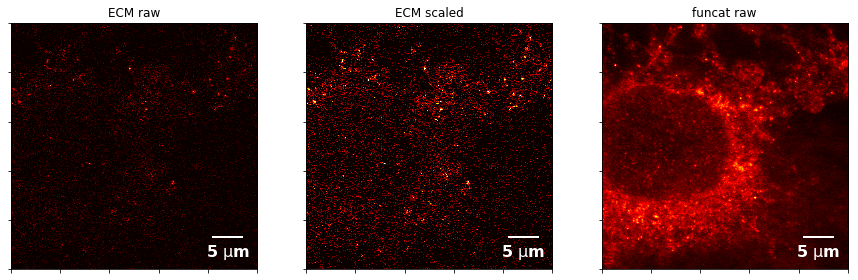

In [311]:
ecm_channel_no=2
funcat_channel_no=1
randomno=np.random.randint(1,len(results["filename"]))
#ecm_channel_no=results["ecmchannelno"][randomno]
#funcat_channel_no=results["funcatchannelno"][randomno]
#autofluorescence_channel_no=results["autofluorescencechannelno"][randomno]

ecm_image_name=results["filename"][randomno]+" Ch"+str(ecm_channel_no)+" {0}.tif"
funcat_image_name=results["filename"][randomno]+" Ch"+str(funcat_channel_no)+" {0}.tif"
#autofluorescence_image_name=results["filename"][randomno]+" Ch"+str(autofluorescence_channel_no)+" {0}.tif"

print("Image name:",results["filename"][randomno].split('/')[-1])
print("Experimental condition:",results["exp condition"][randomno])
ecm_image=pims.open(ecm_image_name)[0]
funcat_image=pims.open(funcat_image_name)[0]
#autofluorescence_image=pims.open(autofluorescence_image_name)[0]


   
figure=plt.figure(figsize=(15,15))
figure.add_subplot(131)
plt.imshow(ecm_image,interpolation='none',cmap='hot')
plt.title('ECM raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(40, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar)
figure.add_subplot(132)
plt.imshow(ecm_image,interpolation='none',cmap='hot',vmin=3*np.min(ecm_image),vmax=0.4*np.max(ecm_image))
plt.title('ECM scaled')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(40, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    
plt.gca().add_artist(scalebar)

figure.add_subplot(133)
plt.imshow(funcat_image,interpolation='none',cmap='hot')
plt.title('funcat raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(40, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    
plt.gca().add_artist(scalebar)

## Load manual spots

In [510]:
#make empty masks
for image in range(0,len(results["filename"])):
    results["Manual ECM spots mask"].append(np.load(results["filename"][image]+'_ecm_spots_mask.npy'))
    results["Manual funcat spots mask"].append(np.load(results["filename"][image]+'_funcat_spots_mask.npy'))

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Culture_ClickChemistry/20190612_funcatdbco_TNR_analyse/withgreenchannel/aha/TIF_imp/1_ExpControl_ecm_sp_ecm_spots_mask.npy'

### Sanity check

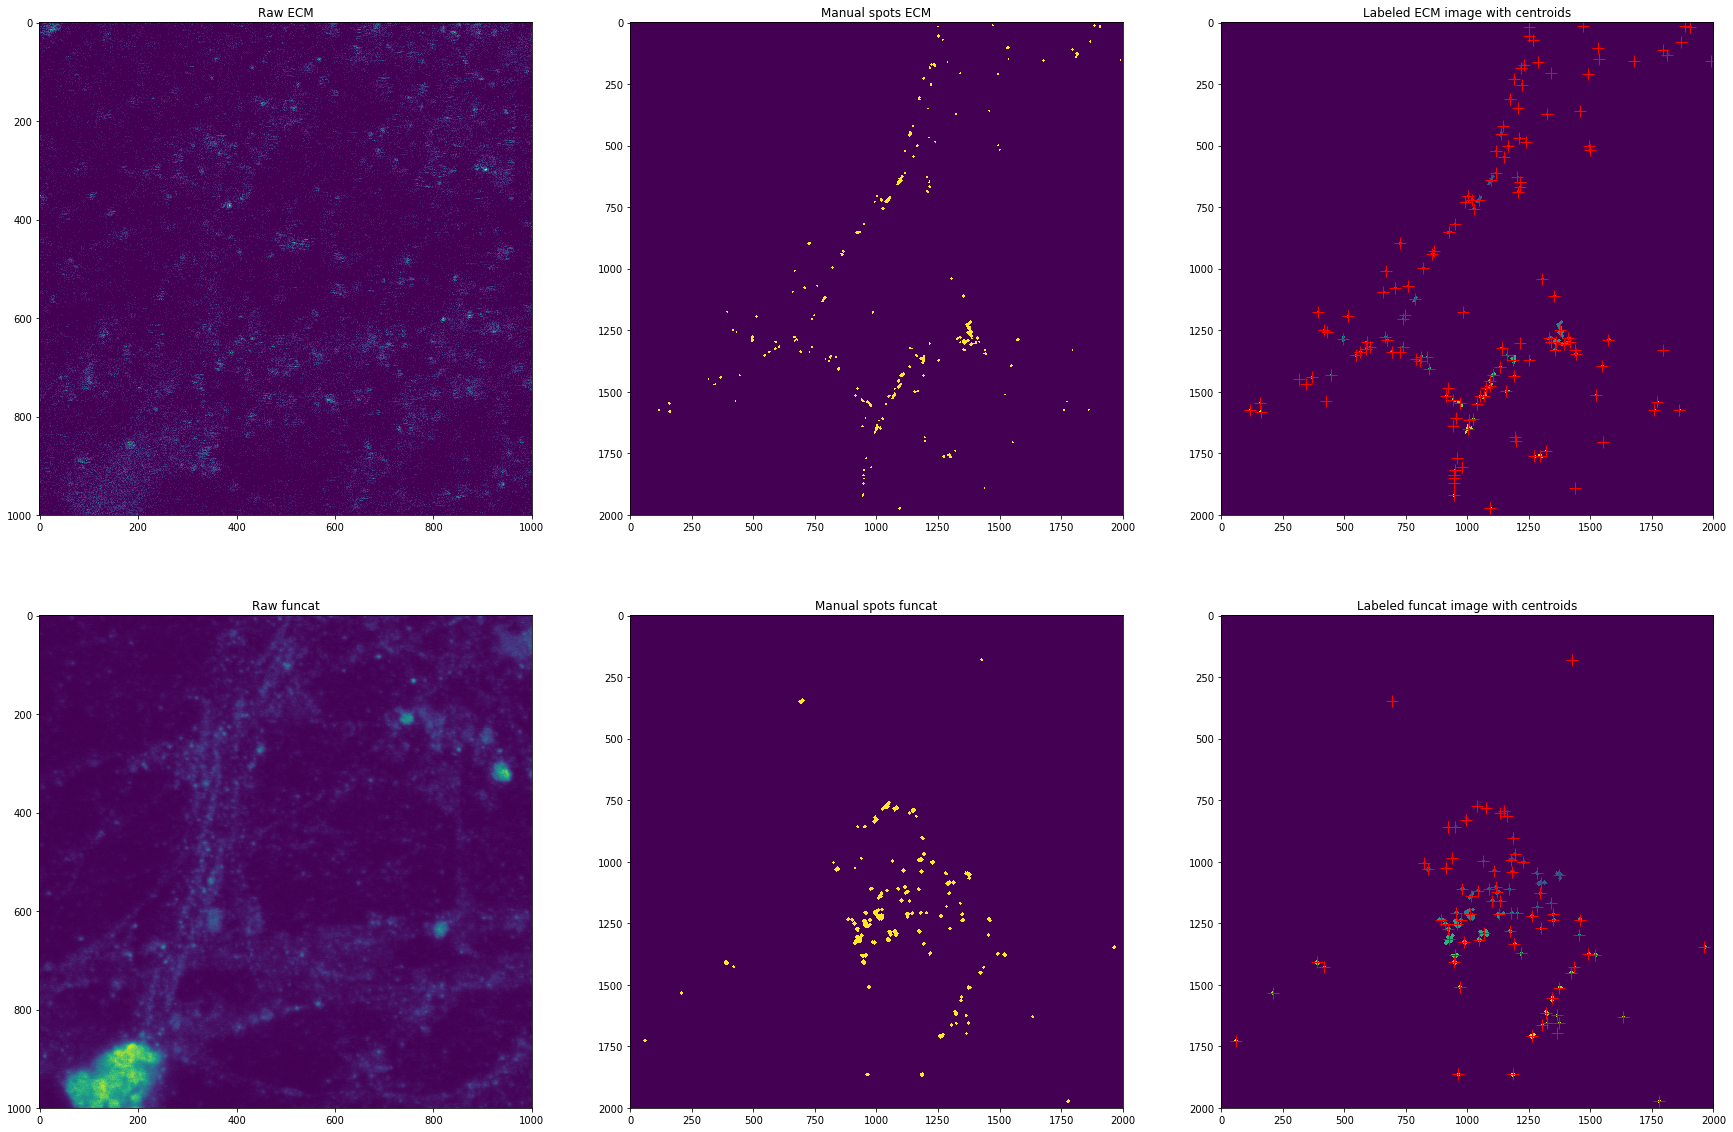

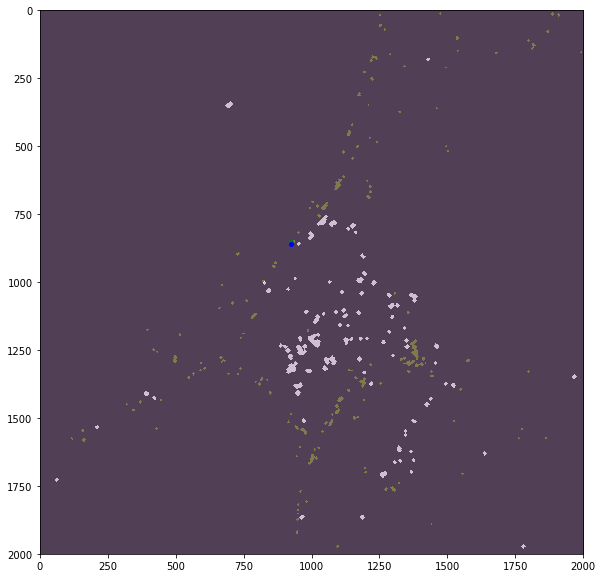

In [248]:
randomno=np.random.randint(1,len(results["filename"]))
ecm_channel_no=results["ecmchannelno"][randomno]
funcat_channel_no=results["funcatchannelno"][randomno]

ecm_image_name=results["filename"][image]+" Ch"+str(ecm_channel_no)+" {0}.tif"
funcat_image_name=results["filename"][image]+" Ch"+str(funcat_channel_no)+" {0}.tif"

ecm_image=pims.open(ecm_image_name)[0]
funcat_image=pims.open(funcat_image_name)[0]

#read spots masks and label
ecm_mask=results["Manual ECM spots mask"][randomno]
funcat_mask=results["Manual funcat spots mask"][randomno]
labeled_ecm=label(ecm_mask)
labeled_funcat=label(funcat_mask)

regionprops_ecm=regionprops(labeled_ecm)
regionprops_funcat=regionprops(labeled_funcat)

ecm_spots_results_sanity=[]
funcat_spots_results_sanity=[]
for i in range(0,len(regionprops_ecm)):
    ecm_spots_results_sanity.append(regionprops_ecm[i]['centroid'])
for i in range(0,len(regionprops_funcat)):
    funcat_spots_results_sanity.append(regionprops_funcat[i]['centroid'])
    
    
#minimum distance between spots
#ecm
a=scipy.spatial.distance.cdist(ecm_spots_results_sanity,funcat_spots_results_sanity,'euclidean')
b=scipy.spatial.distance.cdist(ecm_spots_results_sanity,funcat_spots_results_sanity,'euclidean').min()
c=np.where(a==b)
nearestecm=ecm_spots_results_sanity[c[0][0]]
nearestfuncat=funcat_spots_results_sanity[c[1][0]]
    
fig=plt.figure(figsize=(30,20))
fig.add_subplot(231)
plt.title('Raw ECM')
plt.imshow(ecm_image)
fig.add_subplot(232)
plt.title('Manual spots ECM')
plt.imshow(ecm_mask)
fig.add_subplot(233)
plt.title('Labeled ECM image with centroids')
plt.imshow(labeled_ecm)
for i in range(0,len(ecm_spots_results_sanity)):
    plt.plot(ecm_spots_results_sanity[i][1],ecm_spots_results_sanity[i][0],'+',color='r',markersize=12)

fig.add_subplot(234)
plt.title('Raw funcat')
plt.imshow(funcat_image)
fig.add_subplot(235)
plt.title('Manual spots funcat')
plt.imshow(funcat_mask)
fig.add_subplot(236)
plt.title('Labeled funcat image with centroids')
plt.imshow(labeled_funcat)
for i in range(0,len(funcat_spots_results_sanity)):
    plt.plot(funcat_spots_results_sanity[i][1],funcat_spots_results_sanity[i][0],'+',color='r',markersize=12)
    
newfig=plt.figure(figsize=(10,10))
plt.imshow(ecm_mask,cmap='viridis',alpha=0.5)
plt.imshow(funcat_mask,cmap='gray',alpha=0.5)
plt.plot(nearestecm[1],nearestecm[0],'o',markersize=4,color='g')
plt.plot(nearestfuncat[1],nearestfuncat[0],'o',markersize=4,color='b')

## image for ppt

In [313]:
len(df_ecm)

6076

In [511]:
protein="AHA"
dfpic=df_ecm[df_ecm["Protein"]==protein]
randomno=np.random.randint(0,len(dfpic))
file=dfpic["filename"][randomno]

In [512]:
file

'/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Culture_ClickChemistry/20190612_funcatdbco_TNR_analyse/withgreenchannel/aha/TIF_imp/8_ExpControl'

In [515]:
resultsdf=pd.DataFrame(results)
len(resultsdf)

ValueError: arrays must all be same length

In [516]:
resultsdf.index[resultsdf["filename"]==file].tolist()[0]

8

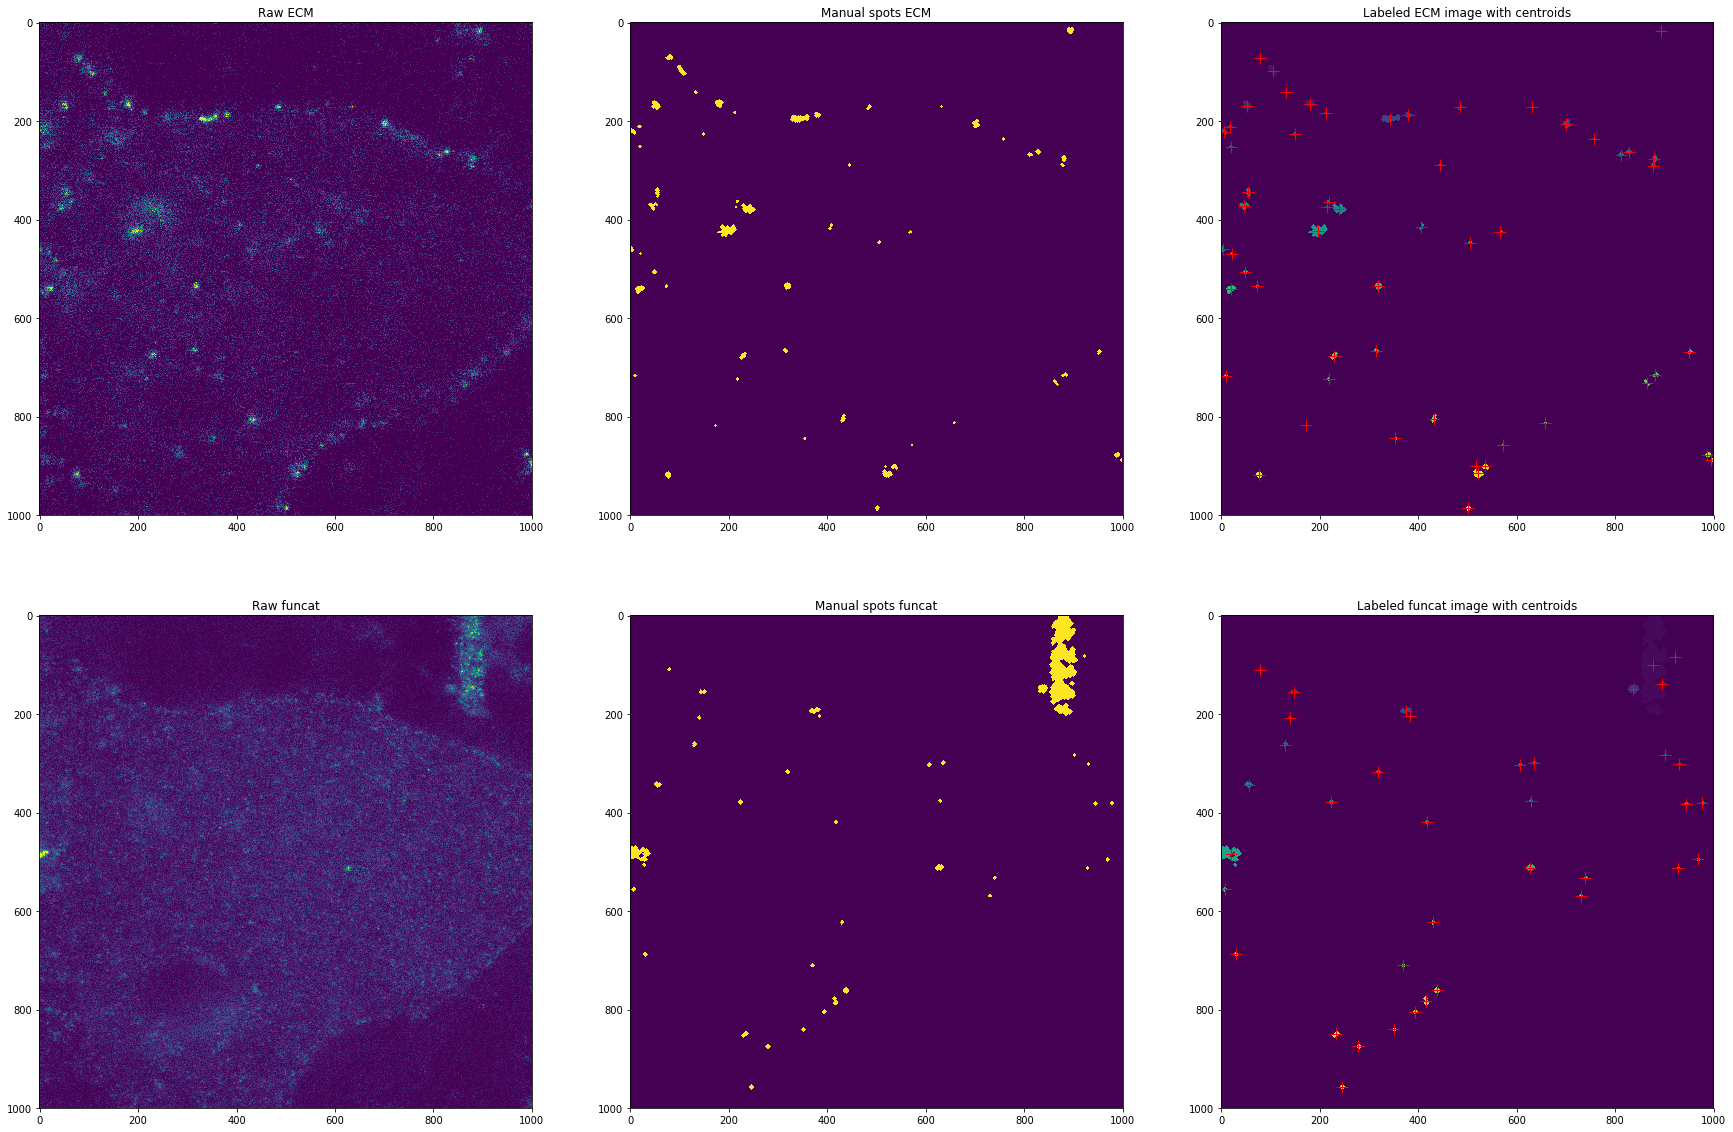

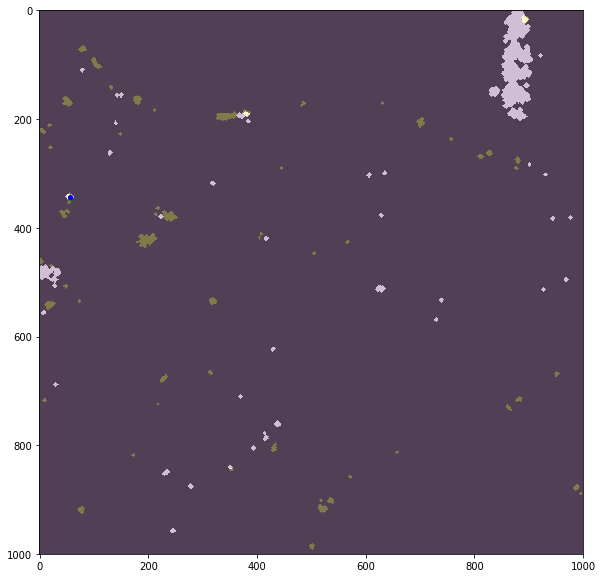

In [523]:
protein="AHA"
dfpic=df_ecm[df_ecm["Protein"]==protein]
randomno=np.random.randint(1,len(dfpic))
file=dfpic["filename"][randomno]
loca=resultsdf.index[resultsdf["filename"]==file].tolist()[0]

ecm_image_name=file+" Ch"+str(ecm_channel_no)+" {0}.tif"
funcat_image_name=file+" Ch"+str(funcat_channel_no)+" {0}.tif"

ecm_image=pims.open(ecm_image_name)[0]
funcat_image=pims.open(funcat_image_name)[0]

#read spots masks and label
ecm_mask=results["Manual ECM spots mask"][loca]
funcat_mask=results["Manual funcat spots mask"][loca]
labeled_ecm=skimage.measure.label(ecm_mask)
labeled_funcat=skimage.measure.label(funcat_mask)

regionprops_ecm=regionprops(labeled_ecm)
regionprops_funcat=regionprops(labeled_funcat)

ecm_spots_results_sanity=[]
funcat_spots_results_sanity=[]
for i in range(0,len(regionprops_ecm)):
    ecm_spots_results_sanity.append(regionprops_ecm[i]['centroid'])
for i in range(0,len(regionprops_funcat)):
    funcat_spots_results_sanity.append(regionprops_funcat[i]['centroid'])
    
    
#minimum distance between spots
#ecm
a=scipy.spatial.distance.cdist(ecm_spots_results_sanity,funcat_spots_results_sanity,'euclidean')
b=scipy.spatial.distance.cdist(ecm_spots_results_sanity,funcat_spots_results_sanity,'euclidean').min()
c=np.where(a==b)
nearestecm=ecm_spots_results_sanity[c[0][0]]
nearestfuncat=funcat_spots_results_sanity[c[1][0]]
    
fig=plt.figure(figsize=(30,20))
fig.add_subplot(231)
plt.title('Raw ECM')
plt.imshow(ecm_image,cmap='viridis',vmin=0.1*np.mean(ecm_image),vmax=0.4*np.max(ecm_image))
fig.add_subplot(232)
plt.title('Manual spots ECM')
plt.imshow(ecm_mask)
fig.add_subplot(233)
plt.title('Labeled ECM image with centroids')
plt.imshow(labeled_ecm)
for i in range(0,len(ecm_spots_results_sanity)):
    plt.plot(ecm_spots_results_sanity[i][1],ecm_spots_results_sanity[i][0],'+',color='r',markersize=12)

fig.add_subplot(234)
plt.title('Raw funcat')
plt.imshow(funcat_image,cmap='viridis',vmin=0.1*np.mean(funcat_image),vmax=0.4*np.max(funcat_image))
fig.add_subplot(235)
plt.title('Manual spots funcat')
plt.imshow(funcat_mask)
fig.add_subplot(236)
plt.title('Labeled funcat image with centroids')
plt.imshow(labeled_funcat)
for i in range(0,len(funcat_spots_results_sanity)):
    plt.plot(funcat_spots_results_sanity[i][1],funcat_spots_results_sanity[i][0],'+',color='r',markersize=12)
    
newfig=plt.figure(figsize=(10,10))
plt.imshow(ecm_mask,cmap='viridis',alpha=0.5)
plt.imshow(funcat_mask,cmap='gray',alpha=0.5)
plt.plot(nearestecm[1],nearestecm[0],'o',markersize=4,color='g')
plt.plot(nearestfuncat[1],nearestfuncat[0],'o',markersize=4,color='b')

## Batch analysis on spots

### Dictionary of spot regionprops

In [101]:
## make spots dictionaries
ecm_spots_results={"filename":[],
               "exp condition":[],
               "spotno":[],
                   "centroid":[],
                   "size":[],
               "distance to nearest funcat centroid":[],
                 "distance to nearest funcat centroid [nms]":[]
                  }
funcat_spots_results={"filename":[],
               "exp condition":[],
               "spotno":[],
                   "centroid":[],
                   "size":[],
               "distance to nearest ecm centroid":[],
                       "distance to nearest ecm centroid [nms]":[]}

for image in range(0,len(results["filename"])):
    print('Calculating image no ' + str(image+1) + ' out of' + str(len(results["filename"])))
    #read images
    ecm_channel_no=results["ecmchannelno"][image]
    funcat_channel_no=results["funcatchannelno"][image]

    ecm_image_name=results["filename"][image]+" Ch"+str(ecm_channel_no)+" {0}.tif"
    funcat_image_name=results["filename"][image]+" Ch"+str(funcat_channel_no)+" {0}.tif"

    print("Image name:",results["filename"][image].split('/')[-1])
    print("Experimental condition:",results["exp condition"][image])
    ecm_image=pims.open(ecm_image_name)[0]
    funcat_image=pims.open(funcat_image_name)[0]
    
    #read spots masks and label
    ecm_mask=results["Manual ECM spots mask"][image]
    funcat_mask=results["Manual funcat spots mask"][image]
    labeled_ecm=label(ecm_mask)
    labeled_funcat=label(funcat_mask)
    
    regionprops_ecm=regionprops(labeled_ecm)
    regionprops_funcat=regionprops(labeled_funcat)

    for i in range(0,len(regionprops_ecm)):
        ecm_spots_results["filename"].append(results["filename"][image])
        ecm_spots_results["exp condition"].append(results["exp condition"][image])
        ecm_spots_results["spotno"].append(i)
        ecm_spots_results["centroid"].append(regionprops_ecm[i]['centroid'])
        ecm_spots_results["size"].append(regionprops_ecm[i]['area'])
    for i in range(0,len(regionprops_funcat)):
        funcat_spots_results["filename"].append(results["filename"][image])
        funcat_spots_results["exp condition"].append(results["exp condition"][image])
        funcat_spots_results["spotno"].append(i)
        funcat_spots_results["centroid"].append(regionprops_funcat[i]['centroid'])
        funcat_spots_results["size"].append(regionprops_funcat[i]['area'])
    

Calculating image no 1 out of89
Image name: 1_ExpControl
Experimental condition: TIF_imp
Calculating image no 2 out of89
Image name: 10_ExpControl
Experimental condition: TIF_imp
Calculating image no 3 out of89
Image name: 2_ExpControl
Experimental condition: TIF_imp
Calculating image no 4 out of89
Image name: 3_ExpControl
Experimental condition: TIF_imp
Calculating image no 5 out of89
Image name: 4_ExpControl
Experimental condition: TIF_imp
Calculating image no 6 out of89
Image name: 5_ExpControl
Experimental condition: TIF_imp
Calculating image no 7 out of89
Image name: 6_ExpControl
Experimental condition: TIF_imp
Calculating image no 8 out of89
Image name: 7_ExpControl
Experimental condition: TIF_imp
Calculating image no 9 out of89
Image name: 8_ExpControl
Experimental condition: TIF_imp
Calculating image no 10 out of89
Image name: 9_ExpControl
Experimental condition: TIF_imp
Calculating image no 11 out of89
Image name: 1_ExpControl
Experimental condition: TIF_imp
Calculating image 

Calculating image no 89 out of89
Image name: 9_ExpControl
Experimental condition: TIF_imp


### Find the min distances between spots

In [102]:
for i in range(0,len(ecm_spots_results["filename"])):
    print(str(i+1)+' out of ' + str(len(ecm_spots_results["filename"])))
    ecm_spots_results["distance to nearest funcat centroid"].append(
        scipy.spatial.distance.cdist([ecm_spots_results["centroid"][i]],
                                     funcat_spots_results["centroid"],'euclidean').min())
                                   
    ecm_spots_results["distance to nearest funcat centroid [nms]"].append(
        scipy.spatial.distance.cdist([ecm_spots_results["centroid"][i]],
                                     funcat_spots_results["centroid"],'euclidean').min()*25)
    
for i in range(0,len(funcat_spots_results["filename"])):
    print(str(i+1)+' out of ' + str(len(funcat_spots_results["filename"])))
    funcat_spots_results["distance to nearest ecm centroid"].append(
        scipy.spatial.distance.cdist([funcat_spots_results["centroid"][i]],
                                     ecm_spots_results["centroid"],'euclidean').min())
    
                                     
    funcat_spots_results["distance to nearest ecm centroid [nms]"].append(
        scipy.spatial.distance.cdist([funcat_spots_results["centroid"][i]],
                                     ecm_spots_results["centroid"],'euclidean').min()*25)


1 out of 6076
2 out of 6076
3 out of 6076
4 out of 6076
5 out of 6076
6 out of 6076
7 out of 6076
8 out of 6076
9 out of 6076
10 out of 6076
11 out of 6076
12 out of 6076
13 out of 6076
14 out of 6076
15 out of 6076
16 out of 6076
17 out of 6076
18 out of 6076
19 out of 6076
20 out of 6076
21 out of 6076
22 out of 6076
23 out of 6076
24 out of 6076
25 out of 6076
26 out of 6076
27 out of 6076
28 out of 6076
29 out of 6076
30 out of 6076
31 out of 6076
32 out of 6076
33 out of 6076
34 out of 6076
35 out of 6076
36 out of 6076
37 out of 6076
38 out of 6076
39 out of 6076
40 out of 6076
41 out of 6076
42 out of 6076
43 out of 6076
44 out of 6076
45 out of 6076
46 out of 6076
47 out of 6076
48 out of 6076
49 out of 6076
50 out of 6076
51 out of 6076
52 out of 6076
53 out of 6076
54 out of 6076
55 out of 6076
56 out of 6076
57 out of 6076
58 out of 6076
59 out of 6076
60 out of 6076
61 out of 6076
62 out of 6076
63 out of 6076
64 out of 6076
65 out of 6076
66 out of 6076
67 out of 6076
68 o

530 out of 6076
531 out of 6076
532 out of 6076
533 out of 6076
534 out of 6076
535 out of 6076
536 out of 6076
537 out of 6076
538 out of 6076
539 out of 6076
540 out of 6076
541 out of 6076
542 out of 6076
543 out of 6076
544 out of 6076
545 out of 6076
546 out of 6076
547 out of 6076
548 out of 6076
549 out of 6076
550 out of 6076
551 out of 6076
552 out of 6076
553 out of 6076
554 out of 6076
555 out of 6076
556 out of 6076
557 out of 6076
558 out of 6076
559 out of 6076
560 out of 6076
561 out of 6076
562 out of 6076
563 out of 6076
564 out of 6076
565 out of 6076
566 out of 6076
567 out of 6076
568 out of 6076
569 out of 6076
570 out of 6076
571 out of 6076
572 out of 6076
573 out of 6076
574 out of 6076
575 out of 6076
576 out of 6076
577 out of 6076
578 out of 6076
579 out of 6076
580 out of 6076
581 out of 6076
582 out of 6076
583 out of 6076
584 out of 6076
585 out of 6076
586 out of 6076
587 out of 6076
588 out of 6076
589 out of 6076
590 out of 6076
591 out of 6076
592 out 

1067 out of 6076
1068 out of 6076
1069 out of 6076
1070 out of 6076
1071 out of 6076
1072 out of 6076
1073 out of 6076
1074 out of 6076
1075 out of 6076
1076 out of 6076
1077 out of 6076
1078 out of 6076
1079 out of 6076
1080 out of 6076
1081 out of 6076
1082 out of 6076
1083 out of 6076
1084 out of 6076
1085 out of 6076
1086 out of 6076
1087 out of 6076
1088 out of 6076
1089 out of 6076
1090 out of 6076
1091 out of 6076
1092 out of 6076
1093 out of 6076
1094 out of 6076
1095 out of 6076
1096 out of 6076
1097 out of 6076
1098 out of 6076
1099 out of 6076
1100 out of 6076
1101 out of 6076
1102 out of 6076
1103 out of 6076
1104 out of 6076
1105 out of 6076
1106 out of 6076
1107 out of 6076
1108 out of 6076
1109 out of 6076
1110 out of 6076
1111 out of 6076
1112 out of 6076
1113 out of 6076
1114 out of 6076
1115 out of 6076
1116 out of 6076
1117 out of 6076
1118 out of 6076
1119 out of 6076
1120 out of 6076
1121 out of 6076
1122 out of 6076
1123 out of 6076
1124 out of 6076
1125 out of 60

1556 out of 6076
1557 out of 6076
1558 out of 6076
1559 out of 6076
1560 out of 6076
1561 out of 6076
1562 out of 6076
1563 out of 6076
1564 out of 6076
1565 out of 6076
1566 out of 6076
1567 out of 6076
1568 out of 6076
1569 out of 6076
1570 out of 6076
1571 out of 6076
1572 out of 6076
1573 out of 6076
1574 out of 6076
1575 out of 6076
1576 out of 6076
1577 out of 6076
1578 out of 6076
1579 out of 6076
1580 out of 6076
1581 out of 6076
1582 out of 6076
1583 out of 6076
1584 out of 6076
1585 out of 6076
1586 out of 6076
1587 out of 6076
1588 out of 6076
1589 out of 6076
1590 out of 6076
1591 out of 6076
1592 out of 6076
1593 out of 6076
1594 out of 6076
1595 out of 6076
1596 out of 6076
1597 out of 6076
1598 out of 6076
1599 out of 6076
1600 out of 6076
1601 out of 6076
1602 out of 6076
1603 out of 6076
1604 out of 6076
1605 out of 6076
1606 out of 6076
1607 out of 6076
1608 out of 6076
1609 out of 6076
1610 out of 6076
1611 out of 6076
1612 out of 6076
1613 out of 6076
1614 out of 60

2053 out of 6076
2054 out of 6076
2055 out of 6076
2056 out of 6076
2057 out of 6076
2058 out of 6076
2059 out of 6076
2060 out of 6076
2061 out of 6076
2062 out of 6076
2063 out of 6076
2064 out of 6076
2065 out of 6076
2066 out of 6076
2067 out of 6076
2068 out of 6076
2069 out of 6076
2070 out of 6076
2071 out of 6076
2072 out of 6076
2073 out of 6076
2074 out of 6076
2075 out of 6076
2076 out of 6076
2077 out of 6076
2078 out of 6076
2079 out of 6076
2080 out of 6076
2081 out of 6076
2082 out of 6076
2083 out of 6076
2084 out of 6076
2085 out of 6076
2086 out of 6076
2087 out of 6076
2088 out of 6076
2089 out of 6076
2090 out of 6076
2091 out of 6076
2092 out of 6076
2093 out of 6076
2094 out of 6076
2095 out of 6076
2096 out of 6076
2097 out of 6076
2098 out of 6076
2099 out of 6076
2100 out of 6076
2101 out of 6076
2102 out of 6076
2103 out of 6076
2104 out of 6076
2105 out of 6076
2106 out of 6076
2107 out of 6076
2108 out of 6076
2109 out of 6076
2110 out of 6076
2111 out of 60

2560 out of 6076
2561 out of 6076
2562 out of 6076
2563 out of 6076
2564 out of 6076
2565 out of 6076
2566 out of 6076
2567 out of 6076
2568 out of 6076
2569 out of 6076
2570 out of 6076
2571 out of 6076
2572 out of 6076
2573 out of 6076
2574 out of 6076
2575 out of 6076
2576 out of 6076
2577 out of 6076
2578 out of 6076
2579 out of 6076
2580 out of 6076
2581 out of 6076
2582 out of 6076
2583 out of 6076
2584 out of 6076
2585 out of 6076
2586 out of 6076
2587 out of 6076
2588 out of 6076
2589 out of 6076
2590 out of 6076
2591 out of 6076
2592 out of 6076
2593 out of 6076
2594 out of 6076
2595 out of 6076
2596 out of 6076
2597 out of 6076
2598 out of 6076
2599 out of 6076
2600 out of 6076
2601 out of 6076
2602 out of 6076
2603 out of 6076
2604 out of 6076
2605 out of 6076
2606 out of 6076
2607 out of 6076
2608 out of 6076
2609 out of 6076
2610 out of 6076
2611 out of 6076
2612 out of 6076
2613 out of 6076
2614 out of 6076
2615 out of 6076
2616 out of 6076
2617 out of 6076
2618 out of 60

3046 out of 6076
3047 out of 6076
3048 out of 6076
3049 out of 6076
3050 out of 6076
3051 out of 6076
3052 out of 6076
3053 out of 6076
3054 out of 6076
3055 out of 6076
3056 out of 6076
3057 out of 6076
3058 out of 6076
3059 out of 6076
3060 out of 6076
3061 out of 6076
3062 out of 6076
3063 out of 6076
3064 out of 6076
3065 out of 6076
3066 out of 6076
3067 out of 6076
3068 out of 6076
3069 out of 6076
3070 out of 6076
3071 out of 6076
3072 out of 6076
3073 out of 6076
3074 out of 6076
3075 out of 6076
3076 out of 6076
3077 out of 6076
3078 out of 6076
3079 out of 6076
3080 out of 6076
3081 out of 6076
3082 out of 6076
3083 out of 6076
3084 out of 6076
3085 out of 6076
3086 out of 6076
3087 out of 6076
3088 out of 6076
3089 out of 6076
3090 out of 6076
3091 out of 6076
3092 out of 6076
3093 out of 6076
3094 out of 6076
3095 out of 6076
3096 out of 6076
3097 out of 6076
3098 out of 6076
3099 out of 6076
3100 out of 6076
3101 out of 6076
3102 out of 6076
3103 out of 6076
3104 out of 60

3554 out of 6076
3555 out of 6076
3556 out of 6076
3557 out of 6076
3558 out of 6076
3559 out of 6076
3560 out of 6076
3561 out of 6076
3562 out of 6076
3563 out of 6076
3564 out of 6076
3565 out of 6076
3566 out of 6076
3567 out of 6076
3568 out of 6076
3569 out of 6076
3570 out of 6076
3571 out of 6076
3572 out of 6076
3573 out of 6076
3574 out of 6076
3575 out of 6076
3576 out of 6076
3577 out of 6076
3578 out of 6076
3579 out of 6076
3580 out of 6076
3581 out of 6076
3582 out of 6076
3583 out of 6076
3584 out of 6076
3585 out of 6076
3586 out of 6076
3587 out of 6076
3588 out of 6076
3589 out of 6076
3590 out of 6076
3591 out of 6076
3592 out of 6076
3593 out of 6076
3594 out of 6076
3595 out of 6076
3596 out of 6076
3597 out of 6076
3598 out of 6076
3599 out of 6076
3600 out of 6076
3601 out of 6076
3602 out of 6076
3603 out of 6076
3604 out of 6076
3605 out of 6076
3606 out of 6076
3607 out of 6076
3608 out of 6076
3609 out of 6076
3610 out of 6076
3611 out of 6076
3612 out of 60

4060 out of 6076
4061 out of 6076
4062 out of 6076
4063 out of 6076
4064 out of 6076
4065 out of 6076
4066 out of 6076
4067 out of 6076
4068 out of 6076
4069 out of 6076
4070 out of 6076
4071 out of 6076
4072 out of 6076
4073 out of 6076
4074 out of 6076
4075 out of 6076
4076 out of 6076
4077 out of 6076
4078 out of 6076
4079 out of 6076
4080 out of 6076
4081 out of 6076
4082 out of 6076
4083 out of 6076
4084 out of 6076
4085 out of 6076
4086 out of 6076
4087 out of 6076
4088 out of 6076
4089 out of 6076
4090 out of 6076
4091 out of 6076
4092 out of 6076
4093 out of 6076
4094 out of 6076
4095 out of 6076
4096 out of 6076
4097 out of 6076
4098 out of 6076
4099 out of 6076
4100 out of 6076
4101 out of 6076
4102 out of 6076
4103 out of 6076
4104 out of 6076
4105 out of 6076
4106 out of 6076
4107 out of 6076
4108 out of 6076
4109 out of 6076
4110 out of 6076
4111 out of 6076
4112 out of 6076
4113 out of 6076
4114 out of 6076
4115 out of 6076
4116 out of 6076
4117 out of 6076
4118 out of 60

4557 out of 6076
4558 out of 6076
4559 out of 6076
4560 out of 6076
4561 out of 6076
4562 out of 6076
4563 out of 6076
4564 out of 6076
4565 out of 6076
4566 out of 6076
4567 out of 6076
4568 out of 6076
4569 out of 6076
4570 out of 6076
4571 out of 6076
4572 out of 6076
4573 out of 6076
4574 out of 6076
4575 out of 6076
4576 out of 6076
4577 out of 6076
4578 out of 6076
4579 out of 6076
4580 out of 6076
4581 out of 6076
4582 out of 6076
4583 out of 6076
4584 out of 6076
4585 out of 6076
4586 out of 6076
4587 out of 6076
4588 out of 6076
4589 out of 6076
4590 out of 6076
4591 out of 6076
4592 out of 6076
4593 out of 6076
4594 out of 6076
4595 out of 6076
4596 out of 6076
4597 out of 6076
4598 out of 6076
4599 out of 6076
4600 out of 6076
4601 out of 6076
4602 out of 6076
4603 out of 6076
4604 out of 6076
4605 out of 6076
4606 out of 6076
4607 out of 6076
4608 out of 6076
4609 out of 6076
4610 out of 6076
4611 out of 6076
4612 out of 6076
4613 out of 6076
4614 out of 6076
4615 out of 60

5052 out of 6076
5053 out of 6076
5054 out of 6076
5055 out of 6076
5056 out of 6076
5057 out of 6076
5058 out of 6076
5059 out of 6076
5060 out of 6076
5061 out of 6076
5062 out of 6076
5063 out of 6076
5064 out of 6076
5065 out of 6076
5066 out of 6076
5067 out of 6076
5068 out of 6076
5069 out of 6076
5070 out of 6076
5071 out of 6076
5072 out of 6076
5073 out of 6076
5074 out of 6076
5075 out of 6076
5076 out of 6076
5077 out of 6076
5078 out of 6076
5079 out of 6076
5080 out of 6076
5081 out of 6076
5082 out of 6076
5083 out of 6076
5084 out of 6076
5085 out of 6076
5086 out of 6076
5087 out of 6076
5088 out of 6076
5089 out of 6076
5090 out of 6076
5091 out of 6076
5092 out of 6076
5093 out of 6076
5094 out of 6076
5095 out of 6076
5096 out of 6076
5097 out of 6076
5098 out of 6076
5099 out of 6076
5100 out of 6076
5101 out of 6076
5102 out of 6076
5103 out of 6076
5104 out of 6076
5105 out of 6076
5106 out of 6076
5107 out of 6076
5108 out of 6076
5109 out of 6076
5110 out of 60

5551 out of 6076
5552 out of 6076
5553 out of 6076
5554 out of 6076
5555 out of 6076
5556 out of 6076
5557 out of 6076
5558 out of 6076
5559 out of 6076
5560 out of 6076
5561 out of 6076
5562 out of 6076
5563 out of 6076
5564 out of 6076
5565 out of 6076
5566 out of 6076
5567 out of 6076
5568 out of 6076
5569 out of 6076
5570 out of 6076
5571 out of 6076
5572 out of 6076
5573 out of 6076
5574 out of 6076
5575 out of 6076
5576 out of 6076
5577 out of 6076
5578 out of 6076
5579 out of 6076
5580 out of 6076
5581 out of 6076
5582 out of 6076
5583 out of 6076
5584 out of 6076
5585 out of 6076
5586 out of 6076
5587 out of 6076
5588 out of 6076
5589 out of 6076
5590 out of 6076
5591 out of 6076
5592 out of 6076
5593 out of 6076
5594 out of 6076
5595 out of 6076
5596 out of 6076
5597 out of 6076
5598 out of 6076
5599 out of 6076
5600 out of 6076
5601 out of 6076
5602 out of 6076
5603 out of 6076
5604 out of 6076
5605 out of 6076
5606 out of 6076
5607 out of 6076
5608 out of 6076
5609 out of 60

6053 out of 6076
6054 out of 6076
6055 out of 6076
6056 out of 6076
6057 out of 6076
6058 out of 6076
6059 out of 6076
6060 out of 6076
6061 out of 6076
6062 out of 6076
6063 out of 6076
6064 out of 6076
6065 out of 6076
6066 out of 6076
6067 out of 6076
6068 out of 6076
6069 out of 6076
6070 out of 6076
6071 out of 6076
6072 out of 6076
6073 out of 6076
6074 out of 6076
6075 out of 6076
6076 out of 6076
1 out of 5612
2 out of 5612
3 out of 5612
4 out of 5612
5 out of 5612
6 out of 5612
7 out of 5612
8 out of 5612
9 out of 5612
10 out of 5612
11 out of 5612
12 out of 5612
13 out of 5612
14 out of 5612
15 out of 5612
16 out of 5612
17 out of 5612
18 out of 5612
19 out of 5612
20 out of 5612
21 out of 5612
22 out of 5612
23 out of 5612
24 out of 5612
25 out of 5612
26 out of 5612
27 out of 5612
28 out of 5612
29 out of 5612
30 out of 5612
31 out of 5612
32 out of 5612
33 out of 5612
34 out of 5612
35 out of 5612
36 out of 5612
37 out of 5612
38 out of 5612
39 out of 5612
40 out of 5612
4

518 out of 5612
519 out of 5612
520 out of 5612
521 out of 5612
522 out of 5612
523 out of 5612
524 out of 5612
525 out of 5612
526 out of 5612
527 out of 5612
528 out of 5612
529 out of 5612
530 out of 5612
531 out of 5612
532 out of 5612
533 out of 5612
534 out of 5612
535 out of 5612
536 out of 5612
537 out of 5612
538 out of 5612
539 out of 5612
540 out of 5612
541 out of 5612
542 out of 5612
543 out of 5612
544 out of 5612
545 out of 5612
546 out of 5612
547 out of 5612
548 out of 5612
549 out of 5612
550 out of 5612
551 out of 5612
552 out of 5612
553 out of 5612
554 out of 5612
555 out of 5612
556 out of 5612
557 out of 5612
558 out of 5612
559 out of 5612
560 out of 5612
561 out of 5612
562 out of 5612
563 out of 5612
564 out of 5612
565 out of 5612
566 out of 5612
567 out of 5612
568 out of 5612
569 out of 5612
570 out of 5612
571 out of 5612
572 out of 5612
573 out of 5612
574 out of 5612
575 out of 5612
576 out of 5612
577 out of 5612
578 out of 5612
579 out of 5612
580 out 

1033 out of 5612
1034 out of 5612
1035 out of 5612
1036 out of 5612
1037 out of 5612
1038 out of 5612
1039 out of 5612
1040 out of 5612
1041 out of 5612
1042 out of 5612
1043 out of 5612
1044 out of 5612
1045 out of 5612
1046 out of 5612
1047 out of 5612
1048 out of 5612
1049 out of 5612
1050 out of 5612
1051 out of 5612
1052 out of 5612
1053 out of 5612
1054 out of 5612
1055 out of 5612
1056 out of 5612
1057 out of 5612
1058 out of 5612
1059 out of 5612
1060 out of 5612
1061 out of 5612
1062 out of 5612
1063 out of 5612
1064 out of 5612
1065 out of 5612
1066 out of 5612
1067 out of 5612
1068 out of 5612
1069 out of 5612
1070 out of 5612
1071 out of 5612
1072 out of 5612
1073 out of 5612
1074 out of 5612
1075 out of 5612
1076 out of 5612
1077 out of 5612
1078 out of 5612
1079 out of 5612
1080 out of 5612
1081 out of 5612
1082 out of 5612
1083 out of 5612
1084 out of 5612
1085 out of 5612
1086 out of 5612
1087 out of 5612
1088 out of 5612
1089 out of 5612
1090 out of 5612
1091 out of 56

1539 out of 5612
1540 out of 5612
1541 out of 5612
1542 out of 5612
1543 out of 5612
1544 out of 5612
1545 out of 5612
1546 out of 5612
1547 out of 5612
1548 out of 5612
1549 out of 5612
1550 out of 5612
1551 out of 5612
1552 out of 5612
1553 out of 5612
1554 out of 5612
1555 out of 5612
1556 out of 5612
1557 out of 5612
1558 out of 5612
1559 out of 5612
1560 out of 5612
1561 out of 5612
1562 out of 5612
1563 out of 5612
1564 out of 5612
1565 out of 5612
1566 out of 5612
1567 out of 5612
1568 out of 5612
1569 out of 5612
1570 out of 5612
1571 out of 5612
1572 out of 5612
1573 out of 5612
1574 out of 5612
1575 out of 5612
1576 out of 5612
1577 out of 5612
1578 out of 5612
1579 out of 5612
1580 out of 5612
1581 out of 5612
1582 out of 5612
1583 out of 5612
1584 out of 5612
1585 out of 5612
1586 out of 5612
1587 out of 5612
1588 out of 5612
1589 out of 5612
1590 out of 5612
1591 out of 5612
1592 out of 5612
1593 out of 5612
1594 out of 5612
1595 out of 5612
1596 out of 5612
1597 out of 56

2041 out of 5612
2042 out of 5612
2043 out of 5612
2044 out of 5612
2045 out of 5612
2046 out of 5612
2047 out of 5612
2048 out of 5612
2049 out of 5612
2050 out of 5612
2051 out of 5612
2052 out of 5612
2053 out of 5612
2054 out of 5612
2055 out of 5612
2056 out of 5612
2057 out of 5612
2058 out of 5612
2059 out of 5612
2060 out of 5612
2061 out of 5612
2062 out of 5612
2063 out of 5612
2064 out of 5612
2065 out of 5612
2066 out of 5612
2067 out of 5612
2068 out of 5612
2069 out of 5612
2070 out of 5612
2071 out of 5612
2072 out of 5612
2073 out of 5612
2074 out of 5612
2075 out of 5612
2076 out of 5612
2077 out of 5612
2078 out of 5612
2079 out of 5612
2080 out of 5612
2081 out of 5612
2082 out of 5612
2083 out of 5612
2084 out of 5612
2085 out of 5612
2086 out of 5612
2087 out of 5612
2088 out of 5612
2089 out of 5612
2090 out of 5612
2091 out of 5612
2092 out of 5612
2093 out of 5612
2094 out of 5612
2095 out of 5612
2096 out of 5612
2097 out of 5612
2098 out of 5612
2099 out of 56

2528 out of 5612
2529 out of 5612
2530 out of 5612
2531 out of 5612
2532 out of 5612
2533 out of 5612
2534 out of 5612
2535 out of 5612
2536 out of 5612
2537 out of 5612
2538 out of 5612
2539 out of 5612
2540 out of 5612
2541 out of 5612
2542 out of 5612
2543 out of 5612
2544 out of 5612
2545 out of 5612
2546 out of 5612
2547 out of 5612
2548 out of 5612
2549 out of 5612
2550 out of 5612
2551 out of 5612
2552 out of 5612
2553 out of 5612
2554 out of 5612
2555 out of 5612
2556 out of 5612
2557 out of 5612
2558 out of 5612
2559 out of 5612
2560 out of 5612
2561 out of 5612
2562 out of 5612
2563 out of 5612
2564 out of 5612
2565 out of 5612
2566 out of 5612
2567 out of 5612
2568 out of 5612
2569 out of 5612
2570 out of 5612
2571 out of 5612
2572 out of 5612
2573 out of 5612
2574 out of 5612
2575 out of 5612
2576 out of 5612
2577 out of 5612
2578 out of 5612
2579 out of 5612
2580 out of 5612
2581 out of 5612
2582 out of 5612
2583 out of 5612
2584 out of 5612
2585 out of 5612
2586 out of 56

3014 out of 5612
3015 out of 5612
3016 out of 5612
3017 out of 5612
3018 out of 5612
3019 out of 5612
3020 out of 5612
3021 out of 5612
3022 out of 5612
3023 out of 5612
3024 out of 5612
3025 out of 5612
3026 out of 5612
3027 out of 5612
3028 out of 5612
3029 out of 5612
3030 out of 5612
3031 out of 5612
3032 out of 5612
3033 out of 5612
3034 out of 5612
3035 out of 5612
3036 out of 5612
3037 out of 5612
3038 out of 5612
3039 out of 5612
3040 out of 5612
3041 out of 5612
3042 out of 5612
3043 out of 5612
3044 out of 5612
3045 out of 5612
3046 out of 5612
3047 out of 5612
3048 out of 5612
3049 out of 5612
3050 out of 5612
3051 out of 5612
3052 out of 5612
3053 out of 5612
3054 out of 5612
3055 out of 5612
3056 out of 5612
3057 out of 5612
3058 out of 5612
3059 out of 5612
3060 out of 5612
3061 out of 5612
3062 out of 5612
3063 out of 5612
3064 out of 5612
3065 out of 5612
3066 out of 5612
3067 out of 5612
3068 out of 5612
3069 out of 5612
3070 out of 5612
3071 out of 5612
3072 out of 56

3504 out of 5612
3505 out of 5612
3506 out of 5612
3507 out of 5612
3508 out of 5612
3509 out of 5612
3510 out of 5612
3511 out of 5612
3512 out of 5612
3513 out of 5612
3514 out of 5612
3515 out of 5612
3516 out of 5612
3517 out of 5612
3518 out of 5612
3519 out of 5612
3520 out of 5612
3521 out of 5612
3522 out of 5612
3523 out of 5612
3524 out of 5612
3525 out of 5612
3526 out of 5612
3527 out of 5612
3528 out of 5612
3529 out of 5612
3530 out of 5612
3531 out of 5612
3532 out of 5612
3533 out of 5612
3534 out of 5612
3535 out of 5612
3536 out of 5612
3537 out of 5612
3538 out of 5612
3539 out of 5612
3540 out of 5612
3541 out of 5612
3542 out of 5612
3543 out of 5612
3544 out of 5612
3545 out of 5612
3546 out of 5612
3547 out of 5612
3548 out of 5612
3549 out of 5612
3550 out of 5612
3551 out of 5612
3552 out of 5612
3553 out of 5612
3554 out of 5612
3555 out of 5612
3556 out of 5612
3557 out of 5612
3558 out of 5612
3559 out of 5612
3560 out of 5612
3561 out of 5612
3562 out of 56

3993 out of 5612
3994 out of 5612
3995 out of 5612
3996 out of 5612
3997 out of 5612
3998 out of 5612
3999 out of 5612
4000 out of 5612
4001 out of 5612
4002 out of 5612
4003 out of 5612
4004 out of 5612
4005 out of 5612
4006 out of 5612
4007 out of 5612
4008 out of 5612
4009 out of 5612
4010 out of 5612
4011 out of 5612
4012 out of 5612
4013 out of 5612
4014 out of 5612
4015 out of 5612
4016 out of 5612
4017 out of 5612
4018 out of 5612
4019 out of 5612
4020 out of 5612
4021 out of 5612
4022 out of 5612
4023 out of 5612
4024 out of 5612
4025 out of 5612
4026 out of 5612
4027 out of 5612
4028 out of 5612
4029 out of 5612
4030 out of 5612
4031 out of 5612
4032 out of 5612
4033 out of 5612
4034 out of 5612
4035 out of 5612
4036 out of 5612
4037 out of 5612
4038 out of 5612
4039 out of 5612
4040 out of 5612
4041 out of 5612
4042 out of 5612
4043 out of 5612
4044 out of 5612
4045 out of 5612
4046 out of 5612
4047 out of 5612
4048 out of 5612
4049 out of 5612
4050 out of 5612
4051 out of 56

4485 out of 5612
4486 out of 5612
4487 out of 5612
4488 out of 5612
4489 out of 5612
4490 out of 5612
4491 out of 5612
4492 out of 5612
4493 out of 5612
4494 out of 5612
4495 out of 5612
4496 out of 5612
4497 out of 5612
4498 out of 5612
4499 out of 5612
4500 out of 5612
4501 out of 5612
4502 out of 5612
4503 out of 5612
4504 out of 5612
4505 out of 5612
4506 out of 5612
4507 out of 5612
4508 out of 5612
4509 out of 5612
4510 out of 5612
4511 out of 5612
4512 out of 5612
4513 out of 5612
4514 out of 5612
4515 out of 5612
4516 out of 5612
4517 out of 5612
4518 out of 5612
4519 out of 5612
4520 out of 5612
4521 out of 5612
4522 out of 5612
4523 out of 5612
4524 out of 5612
4525 out of 5612
4526 out of 5612
4527 out of 5612
4528 out of 5612
4529 out of 5612
4530 out of 5612
4531 out of 5612
4532 out of 5612
4533 out of 5612
4534 out of 5612
4535 out of 5612
4536 out of 5612
4537 out of 5612
4538 out of 5612
4539 out of 5612
4540 out of 5612
4541 out of 5612
4542 out of 5612
4543 out of 56

4997 out of 5612
4998 out of 5612
4999 out of 5612
5000 out of 5612
5001 out of 5612
5002 out of 5612
5003 out of 5612
5004 out of 5612
5005 out of 5612
5006 out of 5612
5007 out of 5612
5008 out of 5612
5009 out of 5612
5010 out of 5612
5011 out of 5612
5012 out of 5612
5013 out of 5612
5014 out of 5612
5015 out of 5612
5016 out of 5612
5017 out of 5612
5018 out of 5612
5019 out of 5612
5020 out of 5612
5021 out of 5612
5022 out of 5612
5023 out of 5612
5024 out of 5612
5025 out of 5612
5026 out of 5612
5027 out of 5612
5028 out of 5612
5029 out of 5612
5030 out of 5612
5031 out of 5612
5032 out of 5612
5033 out of 5612
5034 out of 5612
5035 out of 5612
5036 out of 5612
5037 out of 5612
5038 out of 5612
5039 out of 5612
5040 out of 5612
5041 out of 5612
5042 out of 5612
5043 out of 5612
5044 out of 5612
5045 out of 5612
5046 out of 5612
5047 out of 5612
5048 out of 5612
5049 out of 5612
5050 out of 5612
5051 out of 5612
5052 out of 5612
5053 out of 5612
5054 out of 5612
5055 out of 56

5487 out of 5612
5488 out of 5612
5489 out of 5612
5490 out of 5612
5491 out of 5612
5492 out of 5612
5493 out of 5612
5494 out of 5612
5495 out of 5612
5496 out of 5612
5497 out of 5612
5498 out of 5612
5499 out of 5612
5500 out of 5612
5501 out of 5612
5502 out of 5612
5503 out of 5612
5504 out of 5612
5505 out of 5612
5506 out of 5612
5507 out of 5612
5508 out of 5612
5509 out of 5612
5510 out of 5612
5511 out of 5612
5512 out of 5612
5513 out of 5612
5514 out of 5612
5515 out of 5612
5516 out of 5612
5517 out of 5612
5518 out of 5612
5519 out of 5612
5520 out of 5612
5521 out of 5612
5522 out of 5612
5523 out of 5612
5524 out of 5612
5525 out of 5612
5526 out of 5612
5527 out of 5612
5528 out of 5612
5529 out of 5612
5530 out of 5612
5531 out of 5612
5532 out of 5612
5533 out of 5612
5534 out of 5612
5535 out of 5612
5536 out of 5612
5537 out of 5612
5538 out of 5612
5539 out of 5612
5540 out of 5612
5541 out of 5612
5542 out of 5612
5543 out of 5612
5544 out of 5612
5545 out of 56

## Plots

In [103]:
df_ecm=pd.DataFrame(ecm_spots_results)
df_funcat=pd.DataFrame(funcat_spots_results)

### Backup

In [104]:
#os.mkdir(expdir+'results/')
df_ecm.to_csv(path_or_buf=expdir+'results/results_'+str(protein)+'_ecm.csv')
df_funcat.to_csv(path_or_buf=expdir+'results/results_'+str(protein)+'_funcat.csv')

In [12]:
df_ecm=pd.read_csv(expdir+'results/results_'+str(protein)+'.csv')

FileNotFoundError: [Errno 2] File b'/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed culture/Leica confocal/20190522_tnr550_cav1/Bestparams/20190522_tnr550_cav1_plus20mins_crankup_betweenframes/results/results_TNR.csv' does not exist: b'/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed culture/Leica confocal/20190522_tnr550_cav1/Bestparams/20190522_tnr550_cav1_plus20mins_crankup_betweenframes/results/results_TNR.csv'

Text(0.5, 0, 'Distance (nms)')

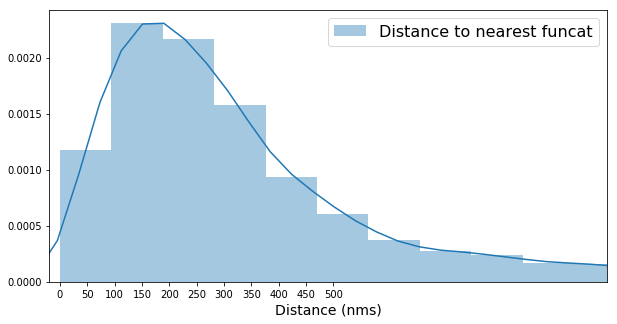

In [108]:
fig=plt.figure(figsize=(10,5))
g=sns.distplot(df_ecm["distance to nearest funcat centroid [nms]"],label="Distance to nearest funcat")
3#g=sns.kdeplot(df_funcat["distance to nearest ecm centroid [nms]"],shade=True)
#g=sns.distplot(df_ecm["distance to nearest funcat centroid [nms]"],label="Distance to nearest funcat")
g.set_xticks(np.linspace(0,500,11))
g.set_xlim([-20,1000])
plt.legend(fontsize=16)
g.set_xlabel('Distance (nms)',fontsize=14)

In [109]:
df_ecm['Protein']='None'
df_ecm.loc[(df_ecm['filename'].str.contains('0502'))&(df_ecm['filename'].str.contains('blocked')), 'Protein'] = 'AHA'
df_ecm.loc[(df_ecm['filename'].str.contains('0522'))&(df_ecm['filename'].str.contains('acth')), 'Protein'] = 'Neg ctrl AchT'
df_ecm.loc[(df_ecm['filename'].str.contains('0522'))&(df_ecm['filename'].str.contains('635')), 'Protein'] = 'Pos ctrl nb635'
df_ecm.loc[(df_ecm['filename'].str.contains('0522'))&(df_ecm['filename'].str.contains('_analyse/funcat')), 'Protein'] = 'AHA'
df_ecm.loc[(df_ecm['filename'].str.contains('0605'))&(df_ecm['filename'].str.contains('withgreenchannel/funcat')), 'Protein'] = 'AHA'
df_ecm.loc[(df_ecm['filename'].str.contains('0605'))&(df_ecm['filename'].str.contains('635')), 'Protein'] = 'Pos ctrl nb635'
df_ecm.loc[(df_ecm['filename'].str.contains('0605'))&(df_ecm['filename'].str.contains('acht')), 'Protein'] = 'Neg ctrl AchT'
df_ecm.loc[(df_ecm['filename'].str.contains('0612'))&(df_ecm['filename'].str.contains('acht')), 'Protein'] = 'Neg ctrl AchT'
df_ecm.loc[(df_ecm['filename'].str.contains('0612'))&(df_ecm['filename'].str.contains('635')), 'Protein'] = 'Pos ctrl nb635'
df_ecm.loc[(df_ecm['filename'].str.contains('0612'))&(df_ecm['filename'].str.contains('aha')), 'Protein'] = 'AHA'

In [64]:
df_ecm['Distance to funcat']='>50nm'
df_ecm.loc[df_ecm["distance to nearest funcat centroid [nms]"]<50,'Distance to funcat']='<50nm'

In [120]:
for protein in df_ecm["Protein"].unique():
    df2plot=df_ecm[df_ecm["Protein"]==protein]
    no=df2plot.loc[df2plot["distance to nearest funcat centroid [nms]"]<25].count()[0]
    total=len(df2plot)
    prop=no/total*100
    print('Under 25nm for '+protein+' = '+str(prop))

Under 25nm for AHA = 0.6397306397306397
Under 25nm for Pos ctrl nb635 = 1.259946949602122
Under 25nm for Neg ctrl AchT = 0.31289111389236546


In [ ]:
for protein in df_ecm["Protein"].unique():
    df2plot=df_ecm[df_ecm["Protein"]==protein]
    no=df2plot.loc[df2plot["distance to nearest funcat centroid [nms] 2"]<25].count()[0]
    total=len(df2plot)
    prop=no/total*100
    print('Under 25nm for '+protein+' = '+str(prop))

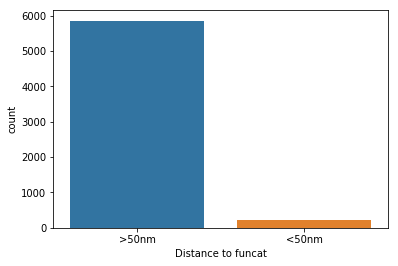

In [65]:
sns.countplot(x="Distance to funcat", data=df_ecm)

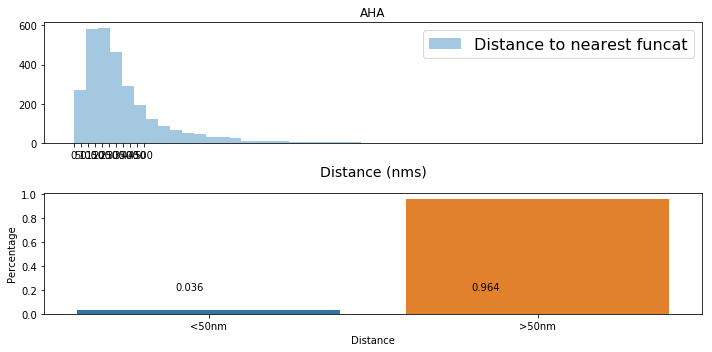

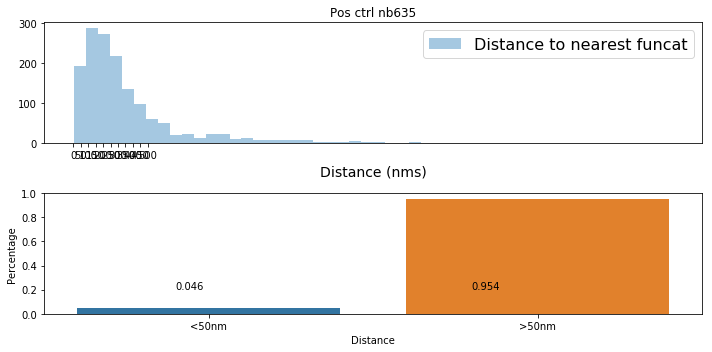

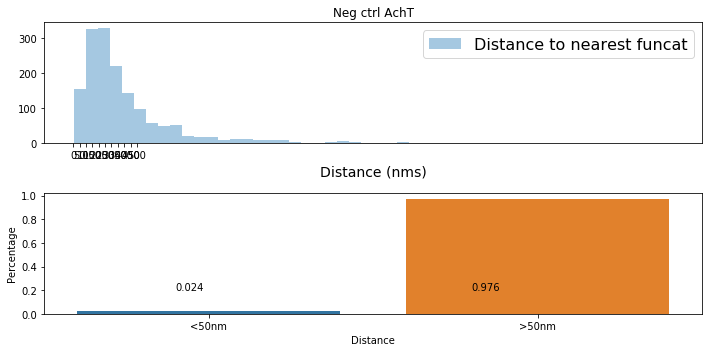

In [67]:
for protein in df_ecm["Protein"].unique():
    #df2plot=df_ecm[(df_ecm["Treatment"]=="Unblocked Control")&(df_ecm["Protein"]==protein)]
    df2plot=df_ecm[(df_ecm["Protein"]==protein)]
    fig=plt.figure(figsize=(10,5))
    fig.add_subplot(211)
    g=sns.distplot(df2plot["distance to nearest funcat centroid [nms]"],label="Distance to nearest funcat",kde=False)
    g.set_xticks(np.linspace(0,500,11))
    #g.set_xlim([-20,700])
    plt.legend(fontsize=16)
    g.set_xlabel('Distance (nms)',fontsize=14)
    plt.title(protein)
    
    fig.add_subplot(212)
    dfcount=df2plot.groupby("Distance to funcat").count()
    smallerthan=dfcount["filename"].unique()[0]
    biggerthan=dfcount["filename"].unique()[1]
    propsmaller=smallerthan/(smallerthan+biggerthan)
    propbigger=biggerthan/(smallerthan+biggerthan)
    dfprops={'Distance':['<50nm','>50nm'],'Percentage':[propsmaller,propbigger]}
    dfprops=pd.DataFrame(dfprops)
    sns.barplot(x="Distance",y="Percentage",data=dfprops)
    plt.text(x=-0.1,y=0.2,s=np.round(propsmaller,3))
    plt.text(x=0.8,y=0.2,s=np.round(propbigger,3))
    
    
    fig.tight_layout()

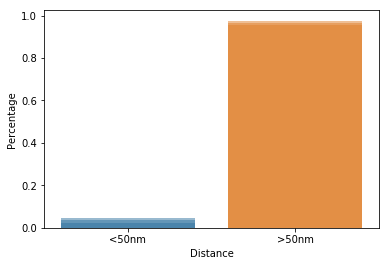

In [100]:
plt.figure()
for protein in df_ecm["Protein"].unique():
    df2plot=df_ecm[df_ecm["Protein"]==protein]
    dfcount=df2plot.groupby("Distance to funcat").count()
    smallerthan=dfcount["filename"].unique()[0]
    biggerthan=dfcount["filename"].unique()[1]
    propsmaller=smallerthan/(smallerthan+biggerthan)
    propbigger=biggerthan/(smallerthan+biggerthan)
    dfprops={'Distance':['<50nm','>50nm'],'Percentage':[propsmaller,propbigger]}
    dfprops=pd.DataFrame(dfprops)
    g=sns.barplot(x="Distance",y="Percentage",data=dfprops,alpha=0.5)

In [247]:
plt.figure(figsize=(20,10))
i=0
for protein in df_ecm["Protein"].unique():
    
    if i==0:
        protein1=protein
    elif i==1:
        protein2=protein
    elif i==2:
        protein3=protein
    df2plot=df_ecm[df_ecm["Protein"]==protein]
    #plt.hist(df2plot["distance to nearest funcat centroid"],alpha=.5,label=protein)
    #plt.figure()
    sns.distplot(df2plot["distance to nearest funcat centroid [nms]"],hist=True,bins=100,label=protein)
    plt.title(protein)
    i+=1
plt.xlim(0,1000)
plt.legend([protein1,protein2,protein3])





AttributeError: module 'seaborn' has no attribute 'set_scale'

<Figure size 1440x720 with 0 Axes>

## Kolmogorov-Smirnov test to compare distributions

In [77]:
df_ecm["Protein"].unique()

array(['AHA', 'Pos ctrl nb635', 'Neg ctrl AchT'], dtype=object)

In [377]:
df_ecm[(df_ecm["Protein"]=="AHA")]["distance to nearest funcat centroid [nms]"].count()

2970

AHA versus positive ctrl: 0.0007537472628963195
AHA versus negative ctrl: 0.0047613469621929794
1.0000000000000004


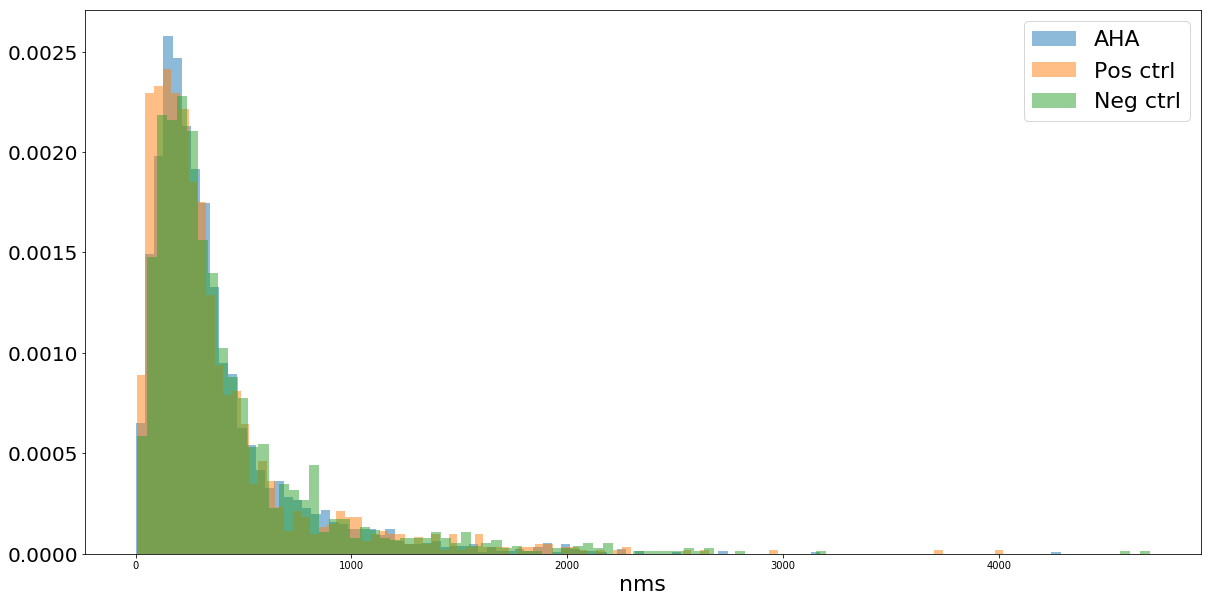

In [372]:

#df2plot=df_ecm[(df_ecm["Treatment"]=="Unblocked Control")&(df_ecm["Protein"]==protein)]
aha=df_ecm[(df_ecm["Protein"]=="AHA")]["distance to nearest funcat centroid [nms]"]
pos=df_ecm[(df_ecm["Protein"]=='Pos ctrl nb635')]["distance to nearest funcat centroid [nms]"]
neg=df_ecm[(df_ecm["Protein"]=='Neg ctrl AchT')]["distance to nearest funcat centroid [nms]"]


    
from scipy import stats
[k,pval]=stats.ks_2samp(aha,pos)
print('AHA versus positive ctrl: '+str(pval))
[k,pval]=stats.ks_2samp(aha,neg)
print('AHA versus negative ctrl: '+str(pval))


plt.figure(figsize=(20,10))
values, bins, _=plt.hist(aha,label="aha",density=True,bins=100,histtype='barstacked',linewidth=2,alpha=.5)
plt.hist(pos,label="pos",density=True,bins=100,histtype='barstacked',linewidth=2,alpha=.5)
plt.hist(neg,label="neg",density=True,bins=100,histtype='barstacked',linewidth=2,alpha=.5)
#plt.xlim(0,1000)
#plt.xticks(np.arange(0,1000,100),size=20)
plt.legend(['AHA','Pos ctrl','Neg ctrl'],fontsize=22)
plt.xlabel('nms',fontsize=22)
plt.yticks(size=20)


area = sum(np.diff(bins)*values)
print(area)

In [151]:
df_ecm["distance to nearest funcat centroid [nms]"].max()

4699.886356094589

## Calculate for TNR rotated image (how much randomly colocalizes)

In [441]:
randomno=np.random.randint(1,len(results["filename"]))

## make spots dictionaries
ecm_spots_results={"filename":[],
               "exp condition":[],
               "spotno":[],
                   "centroid":[],
                   "size":[],
               "distance to nearest funcat centroid":[],
                 "distance to nearest funcat centroid [nms]":[]
                  }
funcat_spots_results={"filename":[],
               "exp condition":[],
               "spotno":[],
                   "centroid":[],
                   "size":[],
               "distance to nearest ecm centroid":[],
                       "distance to nearest ecm centroid [nms]":[]}

for image in range(0,len(results["filename"])):
    print('Calculating image no ' + str(image+1) + ' out of' + str(len(results["filename"])))
    #read images
    #ecm_channel_no=results["ecmchannelno"][image]
    #funcat_channel_no=results["funcatchannelno"][randomno]

    ecm_image_name=results["filename"][image]+" Ch"+str(ecm_channel_no)+" {0}.tif"
    #funcat_image_name=results["filename"][randomno]+" Ch"+str(funcat_channel_no)+" {0}.tif"


    print("Image name:",results["filename"][image].split('/')[-1])
    print("Experimental condition:",results["exp condition"][image])
    ecm_image=pims.open(ecm_image_name)[0]
    #funcat_image=pims.open(funcat_image_name)[0]
    
    #read spots masks and label
    ecm_mask=results["Manual ECM spots mask"][image]
    funcat_mask=results["Manual funcat spots mask"][image]
    funcat_mask= np.rot90(funcat_mask)
    #np.random.shuffle(funcat_mask)
    labeled_ecm=label(ecm_mask)
    labeled_funcat=label(funcat_mask)
    
    regionprops_ecm=regionprops(labeled_ecm)
    regionprops_funcat=regionprops(labeled_funcat)

    for i in range(0,len(regionprops_ecm)):
        ecm_spots_results["filename"].append(results["filename"][image])
        ecm_spots_results["exp condition"].append(results["exp condition"][image])
        ecm_spots_results["spotno"].append(i)
        ecm_spots_results["centroid"].append(regionprops_ecm[i]['centroid'])
        ecm_spots_results["size"].append(regionprops_ecm[i]['area'])
    for i in range(0,len(regionprops_funcat)):
        funcat_spots_results["filename"].append(results["filename"][image])
        funcat_spots_results["exp condition"].append(results["exp condition"][image])
        funcat_spots_results["spotno"].append(i)
        funcat_spots_results["centroid"].append(regionprops_funcat[i]['centroid'])
        funcat_spots_results["size"].append(regionprops_funcat[i]['area'])
    

Calculating image no 1 out of89
Image name: 1_ExpControl
Experimental condition: TIF_imp
Calculating image no 2 out of89
Image name: 10_ExpControl
Experimental condition: TIF_imp
Calculating image no 3 out of89
Image name: 2_ExpControl
Experimental condition: TIF_imp
Calculating image no 4 out of89
Image name: 3_ExpControl
Experimental condition: TIF_imp
Calculating image no 5 out of89
Image name: 4_ExpControl
Experimental condition: TIF_imp
Calculating image no 6 out of89
Image name: 5_ExpControl
Experimental condition: TIF_imp
Calculating image no 7 out of89
Image name: 6_ExpControl
Experimental condition: TIF_imp
Calculating image no 8 out of89
Image name: 7_ExpControl
Experimental condition: TIF_imp
Calculating image no 9 out of89
Image name: 8_ExpControl
Experimental condition: TIF_imp
Calculating image no 10 out of89
Image name: 9_ExpControl
Experimental condition: TIF_imp
Calculating image no 11 out of89
Image name: 1_ExpControl
Experimental condition: TIF_imp
Calculating image 

Calculating image no 89 out of89
Image name: 9_ExpControl
Experimental condition: TIF_imp


In [442]:
for i in range(0,len(ecm_spots_results["filename"])):
    print(str(i+1)+' out of ' + str(len(ecm_spots_results["filename"])))
    ecm_spots_results["distance to nearest funcat centroid"].append(
        scipy.spatial.distance.cdist([ecm_spots_results["centroid"][i]],
                                     funcat_spots_results["centroid"],'euclidean').min())
                                   
    ecm_spots_results["distance to nearest funcat centroid [nms]"].append(
        scipy.spatial.distance.cdist([ecm_spots_results["centroid"][i]],
                                     funcat_spots_results["centroid"],'euclidean').min()*25)
    
for i in range(0,len(funcat_spots_results["filename"])):
    print(str(i+1)+' out of ' + str(len(funcat_spots_results["filename"])))
    funcat_spots_results["distance to nearest ecm centroid"].append(
        scipy.spatial.distance.cdist([funcat_spots_results["centroid"][i]],
                                     ecm_spots_results["centroid"],'euclidean').min())
    
                                     
    funcat_spots_results["distance to nearest ecm centroid [nms]"].append(
        scipy.spatial.distance.cdist([funcat_spots_results["centroid"][i]],
                                     ecm_spots_results["centroid"],'euclidean').min()*25)



1 out of 6076
2 out of 6076
3 out of 6076
4 out of 6076
5 out of 6076
6 out of 6076
7 out of 6076
8 out of 6076
9 out of 6076
10 out of 6076
11 out of 6076
12 out of 6076
13 out of 6076
14 out of 6076
15 out of 6076
16 out of 6076
17 out of 6076
18 out of 6076
19 out of 6076
20 out of 6076
21 out of 6076
22 out of 6076
23 out of 6076
24 out of 6076
25 out of 6076
26 out of 6076
27 out of 6076
28 out of 6076
29 out of 6076
30 out of 6076
31 out of 6076
32 out of 6076
33 out of 6076
34 out of 6076
35 out of 6076
36 out of 6076
37 out of 6076
38 out of 6076
39 out of 6076
40 out of 6076
41 out of 6076
42 out of 6076
43 out of 6076
44 out of 6076
45 out of 6076
46 out of 6076
47 out of 6076
48 out of 6076
49 out of 6076
50 out of 6076
51 out of 6076
52 out of 6076
53 out of 6076
54 out of 6076
55 out of 6076
56 out of 6076
57 out of 6076
58 out of 6076
59 out of 6076
60 out of 6076
61 out of 6076
62 out of 6076
63 out of 6076
64 out of 6076
65 out of 6076
66 out of 6076
67 out of 6076
68 o

522 out of 6076
523 out of 6076
524 out of 6076
525 out of 6076
526 out of 6076
527 out of 6076
528 out of 6076
529 out of 6076
530 out of 6076
531 out of 6076
532 out of 6076
533 out of 6076
534 out of 6076
535 out of 6076
536 out of 6076
537 out of 6076
538 out of 6076
539 out of 6076
540 out of 6076
541 out of 6076
542 out of 6076
543 out of 6076
544 out of 6076
545 out of 6076
546 out of 6076
547 out of 6076
548 out of 6076
549 out of 6076
550 out of 6076
551 out of 6076
552 out of 6076
553 out of 6076
554 out of 6076
555 out of 6076
556 out of 6076
557 out of 6076
558 out of 6076
559 out of 6076
560 out of 6076
561 out of 6076
562 out of 6076
563 out of 6076
564 out of 6076
565 out of 6076
566 out of 6076
567 out of 6076
568 out of 6076
569 out of 6076
570 out of 6076
571 out of 6076
572 out of 6076
573 out of 6076
574 out of 6076
575 out of 6076
576 out of 6076
577 out of 6076
578 out of 6076
579 out of 6076
580 out of 6076
581 out of 6076
582 out of 6076
583 out of 6076
584 out 

1034 out of 6076
1035 out of 6076
1036 out of 6076
1037 out of 6076
1038 out of 6076
1039 out of 6076
1040 out of 6076
1041 out of 6076
1042 out of 6076
1043 out of 6076
1044 out of 6076
1045 out of 6076
1046 out of 6076
1047 out of 6076
1048 out of 6076
1049 out of 6076
1050 out of 6076
1051 out of 6076
1052 out of 6076
1053 out of 6076
1054 out of 6076
1055 out of 6076
1056 out of 6076
1057 out of 6076
1058 out of 6076
1059 out of 6076
1060 out of 6076
1061 out of 6076
1062 out of 6076
1063 out of 6076
1064 out of 6076
1065 out of 6076
1066 out of 6076
1067 out of 6076
1068 out of 6076
1069 out of 6076
1070 out of 6076
1071 out of 6076
1072 out of 6076
1073 out of 6076
1074 out of 6076
1075 out of 6076
1076 out of 6076
1077 out of 6076
1078 out of 6076
1079 out of 6076
1080 out of 6076
1081 out of 6076
1082 out of 6076
1083 out of 6076
1084 out of 6076
1085 out of 6076
1086 out of 6076
1087 out of 6076
1088 out of 6076
1089 out of 6076
1090 out of 6076
1091 out of 6076
1092 out of 60

1517 out of 6076
1518 out of 6076
1519 out of 6076
1520 out of 6076
1521 out of 6076
1522 out of 6076
1523 out of 6076
1524 out of 6076
1525 out of 6076
1526 out of 6076
1527 out of 6076
1528 out of 6076
1529 out of 6076
1530 out of 6076
1531 out of 6076
1532 out of 6076
1533 out of 6076
1534 out of 6076
1535 out of 6076
1536 out of 6076
1537 out of 6076
1538 out of 6076
1539 out of 6076
1540 out of 6076
1541 out of 6076
1542 out of 6076
1543 out of 6076
1544 out of 6076
1545 out of 6076
1546 out of 6076
1547 out of 6076
1548 out of 6076
1549 out of 6076
1550 out of 6076
1551 out of 6076
1552 out of 6076
1553 out of 6076
1554 out of 6076
1555 out of 6076
1556 out of 6076
1557 out of 6076
1558 out of 6076
1559 out of 6076
1560 out of 6076
1561 out of 6076
1562 out of 6076
1563 out of 6076
1564 out of 6076
1565 out of 6076
1566 out of 6076
1567 out of 6076
1568 out of 6076
1569 out of 6076
1570 out of 6076
1571 out of 6076
1572 out of 6076
1573 out of 6076
1574 out of 6076
1575 out of 60

2004 out of 6076
2005 out of 6076
2006 out of 6076
2007 out of 6076
2008 out of 6076
2009 out of 6076
2010 out of 6076
2011 out of 6076
2012 out of 6076
2013 out of 6076
2014 out of 6076
2015 out of 6076
2016 out of 6076
2017 out of 6076
2018 out of 6076
2019 out of 6076
2020 out of 6076
2021 out of 6076
2022 out of 6076
2023 out of 6076
2024 out of 6076
2025 out of 6076
2026 out of 6076
2027 out of 6076
2028 out of 6076
2029 out of 6076
2030 out of 6076
2031 out of 6076
2032 out of 6076
2033 out of 6076
2034 out of 6076
2035 out of 6076
2036 out of 6076
2037 out of 6076
2038 out of 6076
2039 out of 6076
2040 out of 6076
2041 out of 6076
2042 out of 6076
2043 out of 6076
2044 out of 6076
2045 out of 6076
2046 out of 6076
2047 out of 6076
2048 out of 6076
2049 out of 6076
2050 out of 6076
2051 out of 6076
2052 out of 6076
2053 out of 6076
2054 out of 6076
2055 out of 6076
2056 out of 6076
2057 out of 6076
2058 out of 6076
2059 out of 6076
2060 out of 6076
2061 out of 6076
2062 out of 60

2489 out of 6076
2490 out of 6076
2491 out of 6076
2492 out of 6076
2493 out of 6076
2494 out of 6076
2495 out of 6076
2496 out of 6076
2497 out of 6076
2498 out of 6076
2499 out of 6076
2500 out of 6076
2501 out of 6076
2502 out of 6076
2503 out of 6076
2504 out of 6076
2505 out of 6076
2506 out of 6076
2507 out of 6076
2508 out of 6076
2509 out of 6076
2510 out of 6076
2511 out of 6076
2512 out of 6076
2513 out of 6076
2514 out of 6076
2515 out of 6076
2516 out of 6076
2517 out of 6076
2518 out of 6076
2519 out of 6076
2520 out of 6076
2521 out of 6076
2522 out of 6076
2523 out of 6076
2524 out of 6076
2525 out of 6076
2526 out of 6076
2527 out of 6076
2528 out of 6076
2529 out of 6076
2530 out of 6076
2531 out of 6076
2532 out of 6076
2533 out of 6076
2534 out of 6076
2535 out of 6076
2536 out of 6076
2537 out of 6076
2538 out of 6076
2539 out of 6076
2540 out of 6076
2541 out of 6076
2542 out of 6076
2543 out of 6076
2544 out of 6076
2545 out of 6076
2546 out of 6076
2547 out of 60

2974 out of 6076
2975 out of 6076
2976 out of 6076
2977 out of 6076
2978 out of 6076
2979 out of 6076
2980 out of 6076
2981 out of 6076
2982 out of 6076
2983 out of 6076
2984 out of 6076
2985 out of 6076
2986 out of 6076
2987 out of 6076
2988 out of 6076
2989 out of 6076
2990 out of 6076
2991 out of 6076
2992 out of 6076
2993 out of 6076
2994 out of 6076
2995 out of 6076
2996 out of 6076
2997 out of 6076
2998 out of 6076
2999 out of 6076
3000 out of 6076
3001 out of 6076
3002 out of 6076
3003 out of 6076
3004 out of 6076
3005 out of 6076
3006 out of 6076
3007 out of 6076
3008 out of 6076
3009 out of 6076
3010 out of 6076
3011 out of 6076
3012 out of 6076
3013 out of 6076
3014 out of 6076
3015 out of 6076
3016 out of 6076
3017 out of 6076
3018 out of 6076
3019 out of 6076
3020 out of 6076
3021 out of 6076
3022 out of 6076
3023 out of 6076
3024 out of 6076
3025 out of 6076
3026 out of 6076
3027 out of 6076
3028 out of 6076
3029 out of 6076
3030 out of 6076
3031 out of 6076
3032 out of 60

3458 out of 6076
3459 out of 6076
3460 out of 6076
3461 out of 6076
3462 out of 6076
3463 out of 6076
3464 out of 6076
3465 out of 6076
3466 out of 6076
3467 out of 6076
3468 out of 6076
3469 out of 6076
3470 out of 6076
3471 out of 6076
3472 out of 6076
3473 out of 6076
3474 out of 6076
3475 out of 6076
3476 out of 6076
3477 out of 6076
3478 out of 6076
3479 out of 6076
3480 out of 6076
3481 out of 6076
3482 out of 6076
3483 out of 6076
3484 out of 6076
3485 out of 6076
3486 out of 6076
3487 out of 6076
3488 out of 6076
3489 out of 6076
3490 out of 6076
3491 out of 6076
3492 out of 6076
3493 out of 6076
3494 out of 6076
3495 out of 6076
3496 out of 6076
3497 out of 6076
3498 out of 6076
3499 out of 6076
3500 out of 6076
3501 out of 6076
3502 out of 6076
3503 out of 6076
3504 out of 6076
3505 out of 6076
3506 out of 6076
3507 out of 6076
3508 out of 6076
3509 out of 6076
3510 out of 6076
3511 out of 6076
3512 out of 6076
3513 out of 6076
3514 out of 6076
3515 out of 6076
3516 out of 60

3941 out of 6076
3942 out of 6076
3943 out of 6076
3944 out of 6076
3945 out of 6076
3946 out of 6076
3947 out of 6076
3948 out of 6076
3949 out of 6076
3950 out of 6076
3951 out of 6076
3952 out of 6076
3953 out of 6076
3954 out of 6076
3955 out of 6076
3956 out of 6076
3957 out of 6076
3958 out of 6076
3959 out of 6076
3960 out of 6076
3961 out of 6076
3962 out of 6076
3963 out of 6076
3964 out of 6076
3965 out of 6076
3966 out of 6076
3967 out of 6076
3968 out of 6076
3969 out of 6076
3970 out of 6076
3971 out of 6076
3972 out of 6076
3973 out of 6076
3974 out of 6076
3975 out of 6076
3976 out of 6076
3977 out of 6076
3978 out of 6076
3979 out of 6076
3980 out of 6076
3981 out of 6076
3982 out of 6076
3983 out of 6076
3984 out of 6076
3985 out of 6076
3986 out of 6076
3987 out of 6076
3988 out of 6076
3989 out of 6076
3990 out of 6076
3991 out of 6076
3992 out of 6076
3993 out of 6076
3994 out of 6076
3995 out of 6076
3996 out of 6076
3997 out of 6076
3998 out of 6076
3999 out of 60

4430 out of 6076
4431 out of 6076
4432 out of 6076
4433 out of 6076
4434 out of 6076
4435 out of 6076
4436 out of 6076
4437 out of 6076
4438 out of 6076
4439 out of 6076
4440 out of 6076
4441 out of 6076
4442 out of 6076
4443 out of 6076
4444 out of 6076
4445 out of 6076
4446 out of 6076
4447 out of 6076
4448 out of 6076
4449 out of 6076
4450 out of 6076
4451 out of 6076
4452 out of 6076
4453 out of 6076
4454 out of 6076
4455 out of 6076
4456 out of 6076
4457 out of 6076
4458 out of 6076
4459 out of 6076
4460 out of 6076
4461 out of 6076
4462 out of 6076
4463 out of 6076
4464 out of 6076
4465 out of 6076
4466 out of 6076
4467 out of 6076
4468 out of 6076
4469 out of 6076
4470 out of 6076
4471 out of 6076
4472 out of 6076
4473 out of 6076
4474 out of 6076
4475 out of 6076
4476 out of 6076
4477 out of 6076
4478 out of 6076
4479 out of 6076
4480 out of 6076
4481 out of 6076
4482 out of 6076
4483 out of 6076
4484 out of 6076
4485 out of 6076
4486 out of 6076
4487 out of 6076
4488 out of 60

4914 out of 6076
4915 out of 6076
4916 out of 6076
4917 out of 6076
4918 out of 6076
4919 out of 6076
4920 out of 6076
4921 out of 6076
4922 out of 6076
4923 out of 6076
4924 out of 6076
4925 out of 6076
4926 out of 6076
4927 out of 6076
4928 out of 6076
4929 out of 6076
4930 out of 6076
4931 out of 6076
4932 out of 6076
4933 out of 6076
4934 out of 6076
4935 out of 6076
4936 out of 6076
4937 out of 6076
4938 out of 6076
4939 out of 6076
4940 out of 6076
4941 out of 6076
4942 out of 6076
4943 out of 6076
4944 out of 6076
4945 out of 6076
4946 out of 6076
4947 out of 6076
4948 out of 6076
4949 out of 6076
4950 out of 6076
4951 out of 6076
4952 out of 6076
4953 out of 6076
4954 out of 6076
4955 out of 6076
4956 out of 6076
4957 out of 6076
4958 out of 6076
4959 out of 6076
4960 out of 6076
4961 out of 6076
4962 out of 6076
4963 out of 6076
4964 out of 6076
4965 out of 6076
4966 out of 6076
4967 out of 6076
4968 out of 6076
4969 out of 6076
4970 out of 6076
4971 out of 6076
4972 out of 60

5401 out of 6076
5402 out of 6076
5403 out of 6076
5404 out of 6076
5405 out of 6076
5406 out of 6076
5407 out of 6076
5408 out of 6076
5409 out of 6076
5410 out of 6076
5411 out of 6076
5412 out of 6076
5413 out of 6076
5414 out of 6076
5415 out of 6076
5416 out of 6076
5417 out of 6076
5418 out of 6076
5419 out of 6076
5420 out of 6076
5421 out of 6076
5422 out of 6076
5423 out of 6076
5424 out of 6076
5425 out of 6076
5426 out of 6076
5427 out of 6076
5428 out of 6076
5429 out of 6076
5430 out of 6076
5431 out of 6076
5432 out of 6076
5433 out of 6076
5434 out of 6076
5435 out of 6076
5436 out of 6076
5437 out of 6076
5438 out of 6076
5439 out of 6076
5440 out of 6076
5441 out of 6076
5442 out of 6076
5443 out of 6076
5444 out of 6076
5445 out of 6076
5446 out of 6076
5447 out of 6076
5448 out of 6076
5449 out of 6076
5450 out of 6076
5451 out of 6076
5452 out of 6076
5453 out of 6076
5454 out of 6076
5455 out of 6076
5456 out of 6076
5457 out of 6076
5458 out of 6076
5459 out of 60

5890 out of 6076
5891 out of 6076
5892 out of 6076
5893 out of 6076
5894 out of 6076
5895 out of 6076
5896 out of 6076
5897 out of 6076
5898 out of 6076
5899 out of 6076
5900 out of 6076
5901 out of 6076
5902 out of 6076
5903 out of 6076
5904 out of 6076
5905 out of 6076
5906 out of 6076
5907 out of 6076
5908 out of 6076
5909 out of 6076
5910 out of 6076
5911 out of 6076
5912 out of 6076
5913 out of 6076
5914 out of 6076
5915 out of 6076
5916 out of 6076
5917 out of 6076
5918 out of 6076
5919 out of 6076
5920 out of 6076
5921 out of 6076
5922 out of 6076
5923 out of 6076
5924 out of 6076
5925 out of 6076
5926 out of 6076
5927 out of 6076
5928 out of 6076
5929 out of 6076
5930 out of 6076
5931 out of 6076
5932 out of 6076
5933 out of 6076
5934 out of 6076
5935 out of 6076
5936 out of 6076
5937 out of 6076
5938 out of 6076
5939 out of 6076
5940 out of 6076
5941 out of 6076
5942 out of 6076
5943 out of 6076
5944 out of 6076
5945 out of 6076
5946 out of 6076
5947 out of 6076
5948 out of 60

323 out of 5612
324 out of 5612
325 out of 5612
326 out of 5612
327 out of 5612
328 out of 5612
329 out of 5612
330 out of 5612
331 out of 5612
332 out of 5612
333 out of 5612
334 out of 5612
335 out of 5612
336 out of 5612
337 out of 5612
338 out of 5612
339 out of 5612
340 out of 5612
341 out of 5612
342 out of 5612
343 out of 5612
344 out of 5612
345 out of 5612
346 out of 5612
347 out of 5612
348 out of 5612
349 out of 5612
350 out of 5612
351 out of 5612
352 out of 5612
353 out of 5612
354 out of 5612
355 out of 5612
356 out of 5612
357 out of 5612
358 out of 5612
359 out of 5612
360 out of 5612
361 out of 5612
362 out of 5612
363 out of 5612
364 out of 5612
365 out of 5612
366 out of 5612
367 out of 5612
368 out of 5612
369 out of 5612
370 out of 5612
371 out of 5612
372 out of 5612
373 out of 5612
374 out of 5612
375 out of 5612
376 out of 5612
377 out of 5612
378 out of 5612
379 out of 5612
380 out of 5612
381 out of 5612
382 out of 5612
383 out of 5612
384 out of 5612
385 out 

837 out of 5612
838 out of 5612
839 out of 5612
840 out of 5612
841 out of 5612
842 out of 5612
843 out of 5612
844 out of 5612
845 out of 5612
846 out of 5612
847 out of 5612
848 out of 5612
849 out of 5612
850 out of 5612
851 out of 5612
852 out of 5612
853 out of 5612
854 out of 5612
855 out of 5612
856 out of 5612
857 out of 5612
858 out of 5612
859 out of 5612
860 out of 5612
861 out of 5612
862 out of 5612
863 out of 5612
864 out of 5612
865 out of 5612
866 out of 5612
867 out of 5612
868 out of 5612
869 out of 5612
870 out of 5612
871 out of 5612
872 out of 5612
873 out of 5612
874 out of 5612
875 out of 5612
876 out of 5612
877 out of 5612
878 out of 5612
879 out of 5612
880 out of 5612
881 out of 5612
882 out of 5612
883 out of 5612
884 out of 5612
885 out of 5612
886 out of 5612
887 out of 5612
888 out of 5612
889 out of 5612
890 out of 5612
891 out of 5612
892 out of 5612
893 out of 5612
894 out of 5612
895 out of 5612
896 out of 5612
897 out of 5612
898 out of 5612
899 out 

1332 out of 5612
1333 out of 5612
1334 out of 5612
1335 out of 5612
1336 out of 5612
1337 out of 5612
1338 out of 5612
1339 out of 5612
1340 out of 5612
1341 out of 5612
1342 out of 5612
1343 out of 5612
1344 out of 5612
1345 out of 5612
1346 out of 5612
1347 out of 5612
1348 out of 5612
1349 out of 5612
1350 out of 5612
1351 out of 5612
1352 out of 5612
1353 out of 5612
1354 out of 5612
1355 out of 5612
1356 out of 5612
1357 out of 5612
1358 out of 5612
1359 out of 5612
1360 out of 5612
1361 out of 5612
1362 out of 5612
1363 out of 5612
1364 out of 5612
1365 out of 5612
1366 out of 5612
1367 out of 5612
1368 out of 5612
1369 out of 5612
1370 out of 5612
1371 out of 5612
1372 out of 5612
1373 out of 5612
1374 out of 5612
1375 out of 5612
1376 out of 5612
1377 out of 5612
1378 out of 5612
1379 out of 5612
1380 out of 5612
1381 out of 5612
1382 out of 5612
1383 out of 5612
1384 out of 5612
1385 out of 5612
1386 out of 5612
1387 out of 5612
1388 out of 5612
1389 out of 5612
1390 out of 56

1819 out of 5612
1820 out of 5612
1821 out of 5612
1822 out of 5612
1823 out of 5612
1824 out of 5612
1825 out of 5612
1826 out of 5612
1827 out of 5612
1828 out of 5612
1829 out of 5612
1830 out of 5612
1831 out of 5612
1832 out of 5612
1833 out of 5612
1834 out of 5612
1835 out of 5612
1836 out of 5612
1837 out of 5612
1838 out of 5612
1839 out of 5612
1840 out of 5612
1841 out of 5612
1842 out of 5612
1843 out of 5612
1844 out of 5612
1845 out of 5612
1846 out of 5612
1847 out of 5612
1848 out of 5612
1849 out of 5612
1850 out of 5612
1851 out of 5612
1852 out of 5612
1853 out of 5612
1854 out of 5612
1855 out of 5612
1856 out of 5612
1857 out of 5612
1858 out of 5612
1859 out of 5612
1860 out of 5612
1861 out of 5612
1862 out of 5612
1863 out of 5612
1864 out of 5612
1865 out of 5612
1866 out of 5612
1867 out of 5612
1868 out of 5612
1869 out of 5612
1870 out of 5612
1871 out of 5612
1872 out of 5612
1873 out of 5612
1874 out of 5612
1875 out of 5612
1876 out of 5612
1877 out of 56

2301 out of 5612
2302 out of 5612
2303 out of 5612
2304 out of 5612
2305 out of 5612
2306 out of 5612
2307 out of 5612
2308 out of 5612
2309 out of 5612
2310 out of 5612
2311 out of 5612
2312 out of 5612
2313 out of 5612
2314 out of 5612
2315 out of 5612
2316 out of 5612
2317 out of 5612
2318 out of 5612
2319 out of 5612
2320 out of 5612
2321 out of 5612
2322 out of 5612
2323 out of 5612
2324 out of 5612
2325 out of 5612
2326 out of 5612
2327 out of 5612
2328 out of 5612
2329 out of 5612
2330 out of 5612
2331 out of 5612
2332 out of 5612
2333 out of 5612
2334 out of 5612
2335 out of 5612
2336 out of 5612
2337 out of 5612
2338 out of 5612
2339 out of 5612
2340 out of 5612
2341 out of 5612
2342 out of 5612
2343 out of 5612
2344 out of 5612
2345 out of 5612
2346 out of 5612
2347 out of 5612
2348 out of 5612
2349 out of 5612
2350 out of 5612
2351 out of 5612
2352 out of 5612
2353 out of 5612
2354 out of 5612
2355 out of 5612
2356 out of 5612
2357 out of 5612
2358 out of 5612
2359 out of 56

2787 out of 5612
2788 out of 5612
2789 out of 5612
2790 out of 5612
2791 out of 5612
2792 out of 5612
2793 out of 5612
2794 out of 5612
2795 out of 5612
2796 out of 5612
2797 out of 5612
2798 out of 5612
2799 out of 5612
2800 out of 5612
2801 out of 5612
2802 out of 5612
2803 out of 5612
2804 out of 5612
2805 out of 5612
2806 out of 5612
2807 out of 5612
2808 out of 5612
2809 out of 5612
2810 out of 5612
2811 out of 5612
2812 out of 5612
2813 out of 5612
2814 out of 5612
2815 out of 5612
2816 out of 5612
2817 out of 5612
2818 out of 5612
2819 out of 5612
2820 out of 5612
2821 out of 5612
2822 out of 5612
2823 out of 5612
2824 out of 5612
2825 out of 5612
2826 out of 5612
2827 out of 5612
2828 out of 5612
2829 out of 5612
2830 out of 5612
2831 out of 5612
2832 out of 5612
2833 out of 5612
2834 out of 5612
2835 out of 5612
2836 out of 5612
2837 out of 5612
2838 out of 5612
2839 out of 5612
2840 out of 5612
2841 out of 5612
2842 out of 5612
2843 out of 5612
2844 out of 5612
2845 out of 56

3270 out of 5612
3271 out of 5612
3272 out of 5612
3273 out of 5612
3274 out of 5612
3275 out of 5612
3276 out of 5612
3277 out of 5612
3278 out of 5612
3279 out of 5612
3280 out of 5612
3281 out of 5612
3282 out of 5612
3283 out of 5612
3284 out of 5612
3285 out of 5612
3286 out of 5612
3287 out of 5612
3288 out of 5612
3289 out of 5612
3290 out of 5612
3291 out of 5612
3292 out of 5612
3293 out of 5612
3294 out of 5612
3295 out of 5612
3296 out of 5612
3297 out of 5612
3298 out of 5612
3299 out of 5612
3300 out of 5612
3301 out of 5612
3302 out of 5612
3303 out of 5612
3304 out of 5612
3305 out of 5612
3306 out of 5612
3307 out of 5612
3308 out of 5612
3309 out of 5612
3310 out of 5612
3311 out of 5612
3312 out of 5612
3313 out of 5612
3314 out of 5612
3315 out of 5612
3316 out of 5612
3317 out of 5612
3318 out of 5612
3319 out of 5612
3320 out of 5612
3321 out of 5612
3322 out of 5612
3323 out of 5612
3324 out of 5612
3325 out of 5612
3326 out of 5612
3327 out of 5612
3328 out of 56

3753 out of 5612
3754 out of 5612
3755 out of 5612
3756 out of 5612
3757 out of 5612
3758 out of 5612
3759 out of 5612
3760 out of 5612
3761 out of 5612
3762 out of 5612
3763 out of 5612
3764 out of 5612
3765 out of 5612
3766 out of 5612
3767 out of 5612
3768 out of 5612
3769 out of 5612
3770 out of 5612
3771 out of 5612
3772 out of 5612
3773 out of 5612
3774 out of 5612
3775 out of 5612
3776 out of 5612
3777 out of 5612
3778 out of 5612
3779 out of 5612
3780 out of 5612
3781 out of 5612
3782 out of 5612
3783 out of 5612
3784 out of 5612
3785 out of 5612
3786 out of 5612
3787 out of 5612
3788 out of 5612
3789 out of 5612
3790 out of 5612
3791 out of 5612
3792 out of 5612
3793 out of 5612
3794 out of 5612
3795 out of 5612
3796 out of 5612
3797 out of 5612
3798 out of 5612
3799 out of 5612
3800 out of 5612
3801 out of 5612
3802 out of 5612
3803 out of 5612
3804 out of 5612
3805 out of 5612
3806 out of 5612
3807 out of 5612
3808 out of 5612
3809 out of 5612
3810 out of 5612
3811 out of 56

4235 out of 5612
4236 out of 5612
4237 out of 5612
4238 out of 5612
4239 out of 5612
4240 out of 5612
4241 out of 5612
4242 out of 5612
4243 out of 5612
4244 out of 5612
4245 out of 5612
4246 out of 5612
4247 out of 5612
4248 out of 5612
4249 out of 5612
4250 out of 5612
4251 out of 5612
4252 out of 5612
4253 out of 5612
4254 out of 5612
4255 out of 5612
4256 out of 5612
4257 out of 5612
4258 out of 5612
4259 out of 5612
4260 out of 5612
4261 out of 5612
4262 out of 5612
4263 out of 5612
4264 out of 5612
4265 out of 5612
4266 out of 5612
4267 out of 5612
4268 out of 5612
4269 out of 5612
4270 out of 5612
4271 out of 5612
4272 out of 5612
4273 out of 5612
4274 out of 5612
4275 out of 5612
4276 out of 5612
4277 out of 5612
4278 out of 5612
4279 out of 5612
4280 out of 5612
4281 out of 5612
4282 out of 5612
4283 out of 5612
4284 out of 5612
4285 out of 5612
4286 out of 5612
4287 out of 5612
4288 out of 5612
4289 out of 5612
4290 out of 5612
4291 out of 5612
4292 out of 5612
4293 out of 56

4720 out of 5612
4721 out of 5612
4722 out of 5612
4723 out of 5612
4724 out of 5612
4725 out of 5612
4726 out of 5612
4727 out of 5612
4728 out of 5612
4729 out of 5612
4730 out of 5612
4731 out of 5612
4732 out of 5612
4733 out of 5612
4734 out of 5612
4735 out of 5612
4736 out of 5612
4737 out of 5612
4738 out of 5612
4739 out of 5612
4740 out of 5612
4741 out of 5612
4742 out of 5612
4743 out of 5612
4744 out of 5612
4745 out of 5612
4746 out of 5612
4747 out of 5612
4748 out of 5612
4749 out of 5612
4750 out of 5612
4751 out of 5612
4752 out of 5612
4753 out of 5612
4754 out of 5612
4755 out of 5612
4756 out of 5612
4757 out of 5612
4758 out of 5612
4759 out of 5612
4760 out of 5612
4761 out of 5612
4762 out of 5612
4763 out of 5612
4764 out of 5612
4765 out of 5612
4766 out of 5612
4767 out of 5612
4768 out of 5612
4769 out of 5612
4770 out of 5612
4771 out of 5612
4772 out of 5612
4773 out of 5612
4774 out of 5612
4775 out of 5612
4776 out of 5612
4777 out of 5612
4778 out of 56

5203 out of 5612
5204 out of 5612
5205 out of 5612
5206 out of 5612
5207 out of 5612
5208 out of 5612
5209 out of 5612
5210 out of 5612
5211 out of 5612
5212 out of 5612
5213 out of 5612
5214 out of 5612
5215 out of 5612
5216 out of 5612
5217 out of 5612
5218 out of 5612
5219 out of 5612
5220 out of 5612
5221 out of 5612
5222 out of 5612
5223 out of 5612
5224 out of 5612
5225 out of 5612
5226 out of 5612
5227 out of 5612
5228 out of 5612
5229 out of 5612
5230 out of 5612
5231 out of 5612
5232 out of 5612
5233 out of 5612
5234 out of 5612
5235 out of 5612
5236 out of 5612
5237 out of 5612
5238 out of 5612
5239 out of 5612
5240 out of 5612
5241 out of 5612
5242 out of 5612
5243 out of 5612
5244 out of 5612
5245 out of 5612
5246 out of 5612
5247 out of 5612
5248 out of 5612
5249 out of 5612
5250 out of 5612
5251 out of 5612
5252 out of 5612
5253 out of 5612
5254 out of 5612
5255 out of 5612
5256 out of 5612
5257 out of 5612
5258 out of 5612
5259 out of 5612
5260 out of 5612
5261 out of 56

In [443]:
df_random_ecm=pd.DataFrame(ecm_spots_results)
df_random_ecm['Protein']='None'
df_random_ecm.loc[(df_random_ecm['filename'].str.contains('0502'))&(df_random_ecm['filename'].str.contains('blocked')), 'Protein'] = 'AHA'
df_random_ecm.loc[(df_random_ecm['filename'].str.contains('0522'))&(df_random_ecm['filename'].str.contains('acth')), 'Protein'] = 'Neg ctrl AchT'
df_random_ecm.loc[(df_random_ecm['filename'].str.contains('0522'))&(df_random_ecm['filename'].str.contains('635')), 'Protein'] = 'Pos ctrl nb635'
df_random_ecm.loc[(df_random_ecm['filename'].str.contains('0522'))&(df_random_ecm['filename'].str.contains('_analyse/funcat')), 'Protein'] = 'AHA'
df_random_ecm.loc[(df_random_ecm['filename'].str.contains('0605'))&(df_random_ecm['filename'].str.contains('withgreenchannel/funcat')), 'Protein'] = 'AHA'
df_random_ecm.loc[(df_random_ecm['filename'].str.contains('0605'))&(df_random_ecm['filename'].str.contains('635')), 'Protein'] = 'Pos ctrl nb635'
df_random_ecm.loc[(df_random_ecm['filename'].str.contains('0605'))&(df_random_ecm['filename'].str.contains('acht')), 'Protein'] = 'Neg ctrl AchT'
df_random_ecm.loc[(df_random_ecm['filename'].str.contains('0612'))&(df_random_ecm['filename'].str.contains('acht')), 'Protein'] = 'Neg ctrl AchT'
df_random_ecm.loc[(df_random_ecm['filename'].str.contains('0612'))&(df_random_ecm['filename'].str.contains('635')), 'Protein'] = 'Pos ctrl nb635'
df_random_ecm.loc[(df_random_ecm['filename'].str.contains('0612'))&(df_random_ecm['filename'].str.contains('aha')), 'Protein'] = 'AHA'

In [384]:
label=['Neg ctrl vAchT','AHA','Pos ctrl nanbody','Pos ctrl Aggrecan']
vals=np.zeros(4)
i=-1
for protein in df_ecm["Protein"].unique():
    i+=1
    df2plot=df_ecm[df_ecm["Protein"]==protein]
    no=df2plot.loc[df2plot["distance to nearest funcat centroid [nms]"]<50].count()[0]
    total=len(df2plot)
    prop=no/total*100
    print('Under 25nm for '+protein+' = '+str(prop))
    vals[i]=prop

Under 25nm for AHA = 3.5690235690235688
Under 25nm for Pos ctrl nb635 = 4.641909814323608
Under 25nm for Neg ctrl AchT = 2.4405506883604504


In [445]:
label=['Neg ctrl vAchT','AHA','Pos ctrl nanbody','Pos ctrl Aggrecan']
vals2=np.zeros(4)
i=-1
for protein in df_random_ecm["Protein"].unique():
    i+=1
    df2plot=df_random_ecm[df_random_ecm["Protein"]==protein]
    no=df2plot.loc[df2plot["distance to nearest funcat centroid [nms]"]<50].count()[0]
    total=len(df2plot)
    prop=no/total*100
    print('Under 25nm for '+protein+' = '+str(prop))
    vals[i]=prop

Under 25nm for AHA = 2.6262626262626263
Under 25nm for Pos ctrl nb635 = 2.3872679045092835
Under 25nm for Neg ctrl AchT = 2.5031289111389237


In [446]:
vals=[2.4405506883604504,3.5690235690235688,4.641909814323608]
valsrot=[2.5031289111389237,2.6262626262626263,2.3872679045092835]

In [449]:
plt.figure(figsize=(10,5))
sns.barplot(x=[0,1,2])
plt.xticks(ticks=[0,1,2],labels=label,fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Percent under 50nm',fontsize=24)

ValueError: Grouper and axis must be same length

<Figure size 720x360 with 0 Axes>

In [ ]:
data=["label":label,"Condition"]

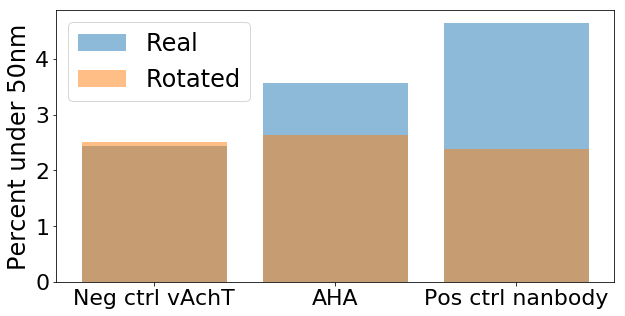

In [463]:
plt.figure(figsize=(10,5))
plt.bar([0,1,2],vals,alpha=.5)
plt.bar([0,1,2],valsrot,alpha=.5)
plt.xticks([0,1,2],label,fontsize=22)
plt.yticks(fontsize=22)
plt.ylabel('Percent under 50nm',fontsize=24)
plt.legend(["Real","Rotated"],fontsize=24)

In [525]:
for protein in df_random_ecm["Protein"].unique():
    df2plot=df_random_ecm[df_random_ecm["Protein"]==protein]
    no=df2plot.loc[df2plot["distance to nearest funcat centroid"]<2].count()[0]
    total=len(df2plot)
    prop=no/total*100
    print('Under 25nm for '+protein+' = '+str(prop))

Under 25nm for AHA = 2.6262626262626263
Under 25nm for Pos ctrl nb635 = 2.3872679045092835
Under 25nm for Neg ctrl AchT = 2.5031289111389237


In [130]:
df2plot["distance to nearest funcat centroid [nms]"].min()

105.84433322486886

## Check coloc for aggrecan 647 tnr 580 - 10nm pxls

In [464]:
expdir='/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed culture/Ecm marker optimization/20171024_ECMmarkers_synapses_2colour/09_TNR580_Agg647_analyse/sted/'
protein="TNR" #TNR,Agg,WFA,HABP

In [465]:
ecmchannelno=2
funcatchannelno=1
#autofluorescencechannelno=3

results = {"filename":[],
          "exp condition":[],
          "ecmchannelno":[],
          "funcatchannelno":[],
           #"autofluorescencechannelno":[],
           "Manual ECM spots mask":[],
           "Manual funcat spots mask":[]
           #"Manual autofluorescence spots mask":[]
          }
           
path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    if "_analyse" in str(filelist[i]):
        if "sted.tif" in str(filelist[i]):
            if ("Pop" in str(filelist[i]))==False:
                if ("save" in str(filelist[i]))==False:
                    if filelist[i].endswith(".tif"): 
                        if str(filelist[i][:-12]) not in str(results["filename"]):
                            results["filename"].append(filelist[i][:-11])
                            results["exp condition"].append(filelist[i][:-12].split('/')[-2])
                            #channeldir="/".join(filelist[i][:-12].split("/")[:-1])
                            #exec(open(channeldir+"/channels.txt").read())
                            results["ecmchannelno"].append(ecmchannelno)
                            results["funcatchannelno"].append(funcatchannelno)
                            #results["autofluorescencechannelno"].append(autofluorescencechannelno)
                                        

Image name: 3_
Experimental condition: sted


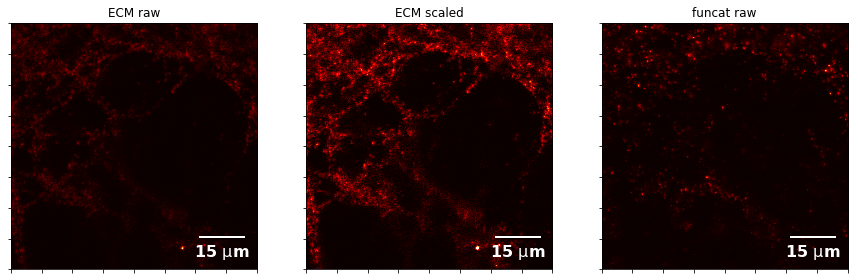

In [408]:
randomno=np.random.randint(1,len(results["filename"]))
#ecm_channel_no=results["ecmchannelno"][randomno]
#funcat_channel_no=results["funcatchannelno"][randomno]
#autofluorescence_channel_no=results["autofluorescencechannelno"][randomno]

ecm_image_name=results["filename"][randomno]+"580sted.tif"
funcat_image_name=results["filename"][randomno]+"attosted.tif"
#autofluorescence_image_name=results["filename"][randomno]+" Ch"+str(autofluorescence_channel_no)+" {0}.tif"

print("Image name:",results["filename"][randomno].split('/')[-1])
print("Experimental condition:",results["exp condition"][randomno])
ecm_image=pims.open(ecm_image_name)[0]
funcat_image=pims.open(funcat_image_name)[0]
#autofluorescence_image=pims.open(autofluorescence_image_name)[0]


   
figure=plt.figure(figsize=(15,15))
figure.add_subplot(131)
plt.imshow(ecm_image,interpolation='none',cmap='hot')
plt.title('ECM raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(40, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar)
figure.add_subplot(132)
plt.imshow(ecm_image,interpolation='none',cmap='hot',vmin=3*np.min(ecm_image),vmax=0.4*np.max(ecm_image))
plt.title('ECM scaled')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(40, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    
plt.gca().add_artist(scalebar)

figure.add_subplot(133)
plt.imshow(funcat_image,interpolation='none',cmap='hot')
plt.title('funcat raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(40, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    
plt.gca().add_artist(scalebar)

In [466]:
#load masks
for image in range(0,len(results["filename"])):
    results["Manual ECM spots mask"].append(np.load(results["filename"][image]+'_ecm_spots_mask.npy'))
    results["Manual funcat spots mask"].append(np.load(results["filename"][image]+'_funcat_spots_mask.npy'))

sanity check

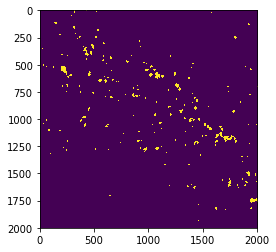

In [469]:
ecm_mask=results["Manual ECM spots mask"][randomno]
plt.imshow(ecm_mask)

min dist: 3.318407337405164


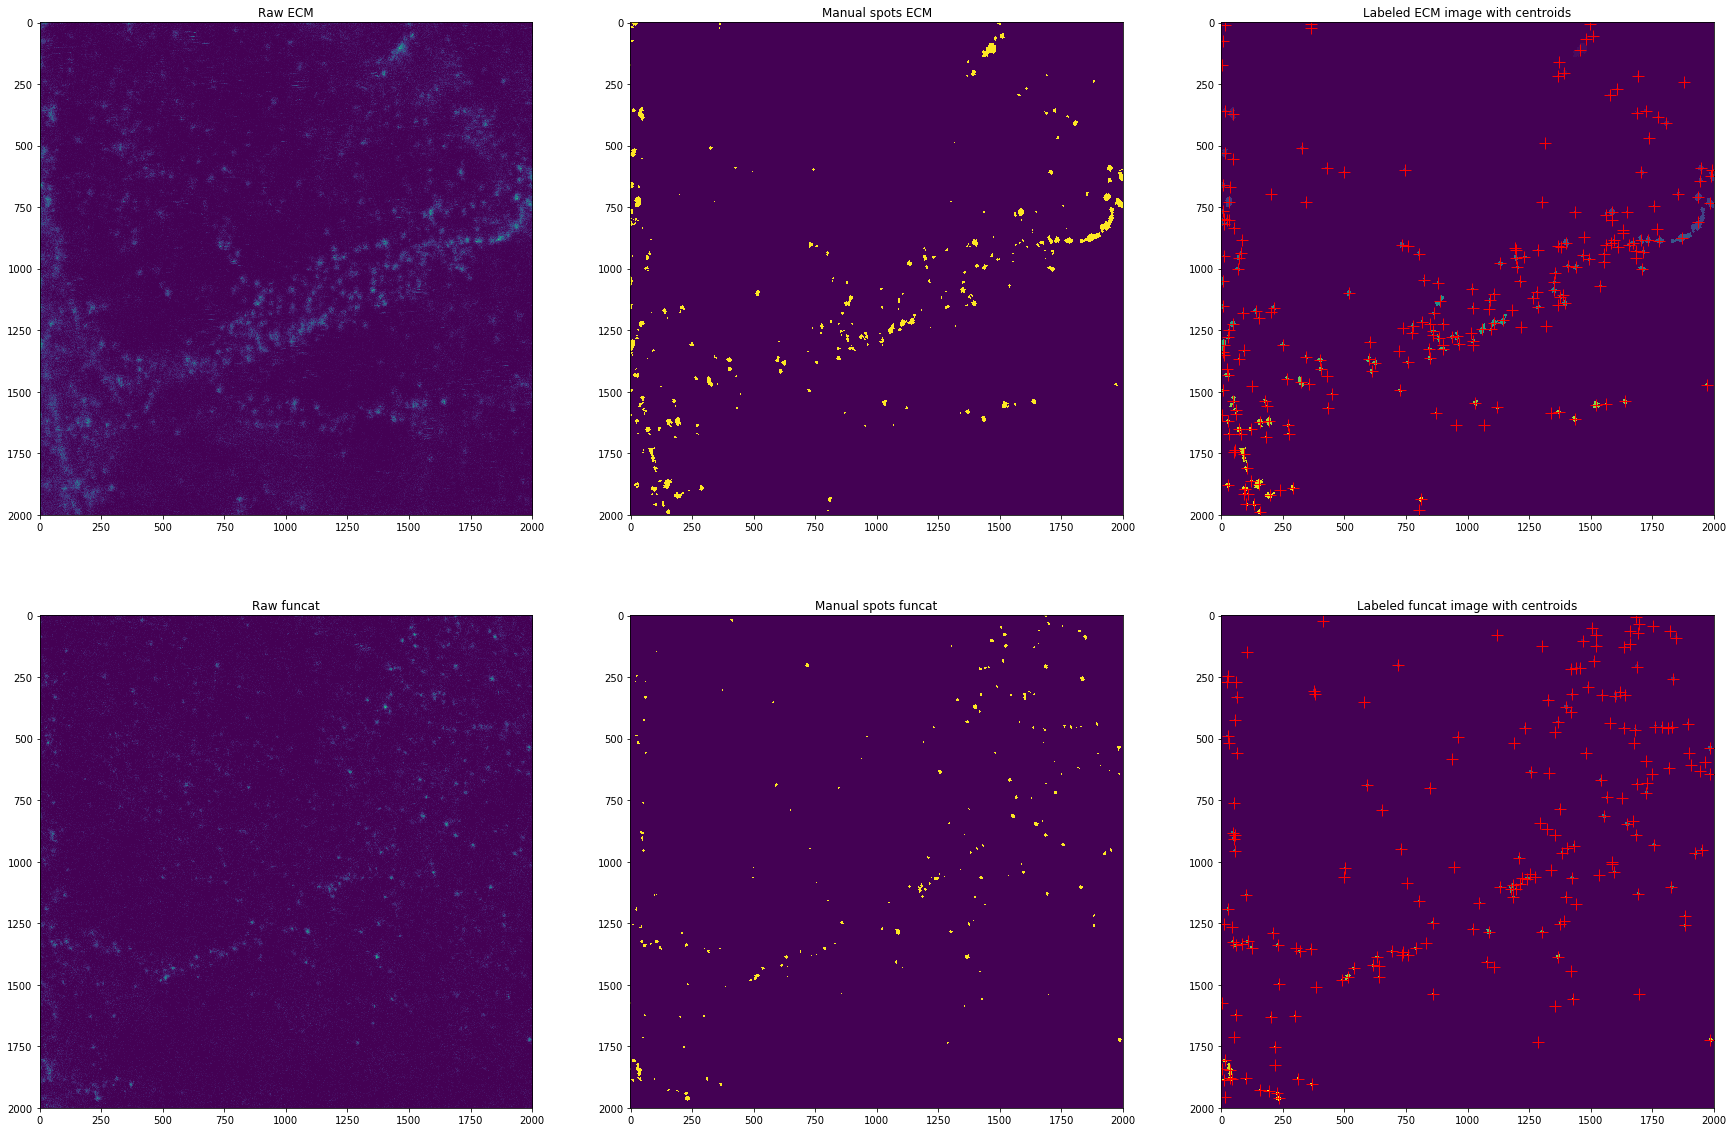

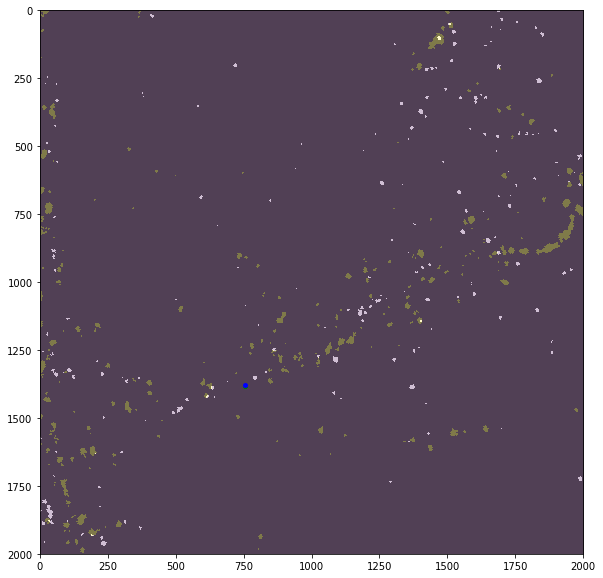

In [480]:
#randomno=np.random.randint(1,5)
randomno=3
ecm_channel_no=results["ecmchannelno"][randomno]
funcat_channel_no=results["funcatchannelno"][randomno]

ecm_image_name=results["filename"][randomno]+"580sted.tif"
funcat_image_name=results["filename"][randomno]+"attosted.tif"


ecm_image=pims.open(ecm_image_name)[0]
funcat_image=pims.open(funcat_image_name)[0]

#read spots masks and label
ecm_mask=results["Manual ECM spots mask"][randomno]
funcat_mask=results["Manual funcat spots mask"][randomno]
labeled_ecm=skimage.measure.label(ecm_mask)
labeled_funcat=skimage.measure.label(funcat_mask)

regionprops_ecm=regionprops(labeled_ecm)
regionprops_funcat=regionprops(labeled_funcat)

ecm_spots_results_sanity=[]
funcat_spots_results_sanity=[]
for i in range(0,len(regionprops_ecm)):
    ecm_spots_results_sanity.append(regionprops_ecm[i]['centroid'])
for i in range(0,len(regionprops_funcat)):
    funcat_spots_results_sanity.append(regionprops_funcat[i]['centroid'])
    
    
#minimum distance between spots
#ecm
a=scipy.spatial.distance.cdist(ecm_spots_results_sanity,funcat_spots_results_sanity,'euclidean')
b=scipy.spatial.distance.cdist(ecm_spots_results_sanity,funcat_spots_results_sanity,'euclidean').min()
c=np.where(a==b)
nearestecm=ecm_spots_results_sanity[c[0][0]]
nearestfuncat=funcat_spots_results_sanity[c[1][0]]
    
print('min dist: '+str(b))
print('mean dist: '+str(a.mean()))
    
fig=plt.figure(figsize=(30,20))
fig.add_subplot(231)
plt.title('Raw ECM')
plt.imshow(ecm_image)
fig.add_subplot(232)
plt.title('Manual spots ECM')
plt.imshow(ecm_mask)
fig.add_subplot(233)
plt.title('Labeled ECM image with centroids')
plt.imshow(labeled_ecm)
for i in range(0,len(ecm_spots_results_sanity)):
    plt.plot(ecm_spots_results_sanity[i][1],ecm_spots_results_sanity[i][0],'+',color='r',markersize=12)

fig.add_subplot(234)
plt.title('Raw funcat')
plt.imshow(funcat_image)
fig.add_subplot(235)
plt.title('Manual spots funcat')
plt.imshow(funcat_mask)
fig.add_subplot(236)
plt.title('Labeled funcat image with centroids')
plt.imshow(labeled_funcat)
for i in range(0,len(funcat_spots_results_sanity)):
    plt.plot(funcat_spots_results_sanity[i][1],funcat_spots_results_sanity[i][0],'+',color='r',markersize=12)
    
newfig=plt.figure(figsize=(10,10))
plt.imshow(ecm_mask,cmap='viridis',alpha=0.5)
plt.imshow(funcat_mask,cmap='gray',alpha=0.5)
plt.plot(nearestecm[1],nearestecm[0],'o',markersize=4,color='g')
plt.plot(nearestfuncat[1],nearestfuncat[0],'o',markersize=4,color='b')

In [ ]:
df_ecm

In [477]:
## make spots dictionaries
ecm_spots_results={"filename":[],
               "exp condition":[],
               "spotno":[],
                   "centroid":[],
                   "size":[],
               "distance to nearest funcat centroid":[],
                 "distance to nearest funcat centroid [nms]":[]
                  }
funcat_spots_results={"filename":[],
               "exp condition":[],
               "spotno":[],
                   "centroid":[],
                   "size":[],
               "distance to nearest ecm centroid":[],
                       "distance to nearest ecm centroid [nms]":[]}

for image in range(0,len(results["filename"])):
    print('Calculating image no ' + str(image+1) + ' out of' + str(len(results["filename"])))
    #read images
    ecm_channel_no=results["ecmchannelno"][image]
    funcat_channel_no=results["funcatchannelno"][image]

    ecm_image_name=results["filename"][randomno]+"580sted.tif"
    funcat_image_name=results["filename"][randomno]+"attosted.tif"


    print("Image name:",results["filename"][image].split('/')[-1])
    print("Experimental condition:",results["exp condition"][image])
    ecm_image=pims.open(ecm_image_name)[0]
    funcat_image=pims.open(funcat_image_name)[0]
    
    #read spots masks and label
    ecm_mask=results["Manual ECM spots mask"][image]
    funcat_mask=results["Manual funcat spots mask"][image]
    labeled_ecm=skimage.measure.label(ecm_mask)
    labeled_funcat=skimage.measure.label(funcat_mask)
    
    regionprops_ecm=regionprops(labeled_ecm)
    regionprops_funcat=regionprops(labeled_funcat)

    for i in range(0,len(regionprops_ecm)):
        ecm_spots_results["filename"].append(results["filename"][image])
        ecm_spots_results["exp condition"].append(results["exp condition"][image])
        ecm_spots_results["spotno"].append(i)
        ecm_spots_results["centroid"].append(regionprops_ecm[i]['centroid'])
        ecm_spots_results["size"].append(regionprops_ecm[i]['area'])
    for i in range(0,len(regionprops_funcat)):
        funcat_spots_results["filename"].append(results["filename"][image])
        funcat_spots_results["exp condition"].append(results["exp condition"][image])
        funcat_spots_results["spotno"].append(i)
        funcat_spots_results["centroid"].append(regionprops_funcat[i]['centroid'])
        funcat_spots_results["size"].append(regionprops_funcat[i]['area'])
    

Calculating image no 1 out of6
Image name: 1_
Experimental condition: sted
Calculating image no 2 out of6
Image name: 3_
Experimental condition: sted
Calculating image no 3 out of6
Image name: 4_
Experimental condition: sted
Calculating image no 4 out of6
Image name: 5_
Experimental condition: sted
Calculating image no 5 out of6
Image name: 6_
Experimental condition: sted
Calculating image no 6 out of6
Image name: 7_
Experimental condition: sted


In [473]:
type(ecm_mask)

numpy.ndarray

In [478]:
for i in range(0,len(ecm_spots_results["filename"])):
    print(str(i+1)+' out of ' + str(len(ecm_spots_results["filename"])))
    ecm_spots_results["distance to nearest funcat centroid"].append(
        scipy.spatial.distance.cdist([ecm_spots_results["centroid"][i]],
                                     funcat_spots_results["centroid"],'euclidean').min())
                                   
    ecm_spots_results["distance to nearest funcat centroid [nms]"].append(
        scipy.spatial.distance.cdist([ecm_spots_results["centroid"][i]],
                                     funcat_spots_results["centroid"],'euclidean').min()*10)
    
for i in range(0,len(funcat_spots_results["filename"])):
    print(str(i+1)+' out of ' + str(len(funcat_spots_results["filename"])))
    funcat_spots_results["distance to nearest ecm centroid"].append(
        scipy.spatial.distance.cdist([funcat_spots_results["centroid"][i]],
                                     ecm_spots_results["centroid"],'euclidean').min())
    
                                     
    funcat_spots_results["distance to nearest ecm centroid [nms]"].append(
        scipy.spatial.distance.cdist([funcat_spots_results["centroid"][i]],
                                     ecm_spots_results["centroid"],'euclidean').min()*10)




1 out of 1218
2 out of 1218
3 out of 1218
4 out of 1218
5 out of 1218
6 out of 1218
7 out of 1218
8 out of 1218
9 out of 1218
10 out of 1218
11 out of 1218
12 out of 1218
13 out of 1218
14 out of 1218
15 out of 1218
16 out of 1218
17 out of 1218
18 out of 1218
19 out of 1218
20 out of 1218
21 out of 1218
22 out of 1218
23 out of 1218
24 out of 1218
25 out of 1218
26 out of 1218
27 out of 1218
28 out of 1218
29 out of 1218
30 out of 1218
31 out of 1218
32 out of 1218
33 out of 1218
34 out of 1218
35 out of 1218
36 out of 1218
37 out of 1218
38 out of 1218
39 out of 1218
40 out of 1218
41 out of 1218
42 out of 1218
43 out of 1218
44 out of 1218
45 out of 1218
46 out of 1218
47 out of 1218
48 out of 1218
49 out of 1218
50 out of 1218
51 out of 1218
52 out of 1218
53 out of 1218
54 out of 1218
55 out of 1218
56 out of 1218
57 out of 1218
58 out of 1218
59 out of 1218
60 out of 1218
61 out of 1218
62 out of 1218
63 out of 1218
64 out of 1218
65 out of 1218
66 out of 1218
67 out of 1218
68 o

543 out of 1218
544 out of 1218
545 out of 1218
546 out of 1218
547 out of 1218
548 out of 1218
549 out of 1218
550 out of 1218
551 out of 1218
552 out of 1218
553 out of 1218
554 out of 1218
555 out of 1218
556 out of 1218
557 out of 1218
558 out of 1218
559 out of 1218
560 out of 1218
561 out of 1218
562 out of 1218
563 out of 1218
564 out of 1218
565 out of 1218
566 out of 1218
567 out of 1218
568 out of 1218
569 out of 1218
570 out of 1218
571 out of 1218
572 out of 1218
573 out of 1218
574 out of 1218
575 out of 1218
576 out of 1218
577 out of 1218
578 out of 1218
579 out of 1218
580 out of 1218
581 out of 1218
582 out of 1218
583 out of 1218
584 out of 1218
585 out of 1218
586 out of 1218
587 out of 1218
588 out of 1218
589 out of 1218
590 out of 1218
591 out of 1218
592 out of 1218
593 out of 1218
594 out of 1218
595 out of 1218
596 out of 1218
597 out of 1218
598 out of 1218
599 out of 1218
600 out of 1218
601 out of 1218
602 out of 1218
603 out of 1218
604 out of 1218
605 out 

1066 out of 1218
1067 out of 1218
1068 out of 1218
1069 out of 1218
1070 out of 1218
1071 out of 1218
1072 out of 1218
1073 out of 1218
1074 out of 1218
1075 out of 1218
1076 out of 1218
1077 out of 1218
1078 out of 1218
1079 out of 1218
1080 out of 1218
1081 out of 1218
1082 out of 1218
1083 out of 1218
1084 out of 1218
1085 out of 1218
1086 out of 1218
1087 out of 1218
1088 out of 1218
1089 out of 1218
1090 out of 1218
1091 out of 1218
1092 out of 1218
1093 out of 1218
1094 out of 1218
1095 out of 1218
1096 out of 1218
1097 out of 1218
1098 out of 1218
1099 out of 1218
1100 out of 1218
1101 out of 1218
1102 out of 1218
1103 out of 1218
1104 out of 1218
1105 out of 1218
1106 out of 1218
1107 out of 1218
1108 out of 1218
1109 out of 1218
1110 out of 1218
1111 out of 1218
1112 out of 1218
1113 out of 1218
1114 out of 1218
1115 out of 1218
1116 out of 1218
1117 out of 1218
1118 out of 1218
1119 out of 1218
1120 out of 1218
1121 out of 1218
1122 out of 1218
1123 out of 1218
1124 out of 12

392 out of 994
393 out of 994
394 out of 994
395 out of 994
396 out of 994
397 out of 994
398 out of 994
399 out of 994
400 out of 994
401 out of 994
402 out of 994
403 out of 994
404 out of 994
405 out of 994
406 out of 994
407 out of 994
408 out of 994
409 out of 994
410 out of 994
411 out of 994
412 out of 994
413 out of 994
414 out of 994
415 out of 994
416 out of 994
417 out of 994
418 out of 994
419 out of 994
420 out of 994
421 out of 994
422 out of 994
423 out of 994
424 out of 994
425 out of 994
426 out of 994
427 out of 994
428 out of 994
429 out of 994
430 out of 994
431 out of 994
432 out of 994
433 out of 994
434 out of 994
435 out of 994
436 out of 994
437 out of 994
438 out of 994
439 out of 994
440 out of 994
441 out of 994
442 out of 994
443 out of 994
444 out of 994
445 out of 994
446 out of 994
447 out of 994
448 out of 994
449 out of 994
450 out of 994
451 out of 994
452 out of 994
453 out of 994
454 out of 994
455 out of 994
456 out of 994
457 out of 994
458 out of

963 out of 994
964 out of 994
965 out of 994
966 out of 994
967 out of 994
968 out of 994
969 out of 994
970 out of 994
971 out of 994
972 out of 994
973 out of 994
974 out of 994
975 out of 994
976 out of 994
977 out of 994
978 out of 994
979 out of 994
980 out of 994
981 out of 994
982 out of 994
983 out of 994
984 out of 994
985 out of 994
986 out of 994
987 out of 994
988 out of 994
989 out of 994
990 out of 994
991 out of 994
992 out of 994
993 out of 994
994 out of 994


In [481]:
df_ctrl_ecm=pd.DataFrame(ecm_spots_results)

In [482]:
df_ctrl_ecm=pd.DataFrame(ecm_spots_results)
df_ctrl_ecm['Protein']='None'
df_ctrl_ecm.loc[(df_ctrl_ecm['filename'].str.contains('0502'))&(df_ctrl_ecm['filename'].str.contains('blocked')), 'Protein'] = 'AHA'
df_ctrl_ecm.loc[(df_ctrl_ecm['filename'].str.contains('0522'))&(df_ctrl_ecm['filename'].str.contains('acth')), 'Protein'] = 'Neg ctrl AchT'
df_ctrl_ecm.loc[(df_ctrl_ecm['filename'].str.contains('0522'))&(df_ctrl_ecm['filename'].str.contains('635')), 'Protein'] = 'Pos ctrl nb635'
df_ctrl_ecm.loc[(df_ctrl_ecm['filename'].str.contains('0522'))&(df_ctrl_ecm['filename'].str.contains('_analyse/funcat')), 'Protein'] = 'AHA'
df_ctrl_ecm.loc[(df_ctrl_ecm['filename'].str.contains('0605'))&(df_ctrl_ecm['filename'].str.contains('withgreenchannel/funcat')), 'Protein'] = 'AHA'
df_ctrl_ecm.loc[(df_ctrl_ecm['filename'].str.contains('0605'))&(df_ctrl_ecm['filename'].str.contains('635')), 'Protein'] = 'Pos ctrl nb635'
df_ctrl_ecm.loc[(df_ctrl_ecm['filename'].str.contains('0605'))&(df_ctrl_ecm['filename'].str.contains('acht')), 'Protein'] = 'Neg ctrl AchT'
df_ctrl_ecm.loc[(df_ctrl_ecm['filename'].str.contains('0612'))&(df_ctrl_ecm['filename'].str.contains('acht')), 'Protein'] = 'Neg ctrl AchT'
df_ctrl_ecm.loc[(df_ctrl_ecm['filename'].str.contains('0612'))&(df_ctrl_ecm['filename'].str.contains('635')), 'Protein'] = 'Pos ctrl nb635'
df_ctrl_ecm.loc[(df_ctrl_ecm['filename'].str.contains('0612'))&(df_ctrl_ecm['filename'].str.contains('aha')), 'Protein'] = 'AHA'

In [524]:

df2plot=df_ctrl_ecm
no=df2plot.loc[df2plot["distance to nearest funcat centroid [nms]"]<50].count()[0]
total=len(df2plot)
prop=no/total*100
print('Under 25nm: '+str(prop))

Under 25nm: 2.955665024630542


In [487]:
df_ctrl_ecm["distance to nearest funcat centroid"].min()

0.9625382691126904

(array([269., 416., 278., 148.,  64.,  27.,   7.,   5.,   2.,   2.]),
 array([   9.62538269,  169.2328832 ,  328.84038371,  488.44788422,
         648.05538472,  807.66288523,  967.27038574, 1126.87788625,
        1286.48538676, 1446.09288726, 1605.70038777]),
 <a list of 10 Patch objects>)

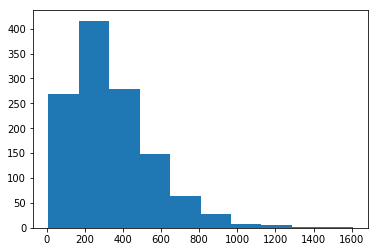

In [392]:
plt.hist(df2plot["distance to nearest funcat centroid [nms]"])